In [177]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.integrate import odeint
import seaborn as sns; sns.set(style = "white")

Hsp104/70/40 disaggregation system simulation was performed to generate the figures shown in **Yoo et al. (2021) "Chaperones avidly disperse native stress-triggered condensates"**.

### 1.0 Non-cooperative model
Schematic:

<img src="model_noncooperative.png" alt="full" width="900" style = "float: center"/>

The model assumes that: <br>
1) Hsp70(ATP) only binds to aggregated/condensed/misfolded substrates, not folded or unfolded substrates

### 1.1 Set rate parameters:
Rates are in min/µM unit (see the table of paramters for detailed sources)

In [178]:
kh = 0.0006 * 60
kh_s = 1.8 * 60
kon_ATP = 2e5 * 60 * 1e-6 #4.5e5 * 60 * 1e-6
koff_ATP = 2 * 60 
kon_ADP = 1.0e3 * 60 * 1e-6 
koff_ADP = 4.7e-4 * 60 
print(koff_ATP/kon_ATP, koff_ADP/kon_ADP, koff_ADP/kon_ATP)

# Nucleotide exchange rates for free Hsp70 are calculated using ATP binding/release rates, 
# as derived in Rios and Barducci (2014). ATP/ADP ratio set to 10. 
kr_atp = 1.33e-4 * 60
k_atp = 1.3e5 * 60 * 1e-6
kr_adp = 0.022 * 60
k_adp = 2.67e5 * 60 * 1e-6

ATP = 1e3
ADP = 1e2

# Nucleotide exchange rates for substrate-bound Hsp70 are for now 
# assumed to be the same as the rates for the free Hsp70. 
# Multiply by acceleration factors "a" and "b" (now both = 1); 
# These acceleration values come in handy when modeling the effect of NEF. 
a = 1
b = 1

kTD = a * kr_atp * ((k_adp * ADP) / (k_atp * ATP + k_adp * ADP))
kDT = b * kr_adp * ((k_atp * ATP) / (k_atp * ATP + k_adp * ADP))

kTD_s = kTD
kDT_s = kDT
print(kTD, kDT)

### Rosenzwieg et al. (2013) measured affinity between ClpB NBD and DnaK NBD ~ 20uM. 
# Assume full length proteins bind little tighter? Assign numbers accordingly. 
kon_104 = 5e5 * 60 * 1e-6
koff_104 = 1e0 * 60
print(koff_104/kon_104)

# unknown; 
kon_ADP_104 = 0
koff_ADP_104 = 100

# extracted from HY's fitted Pab1 dispersal data
k_disagg = 0.2 # per min

# arbitrary for now
k_prime = 10
k_deprime = 1
k_fold = 10 #k_1
k_unfold = 0
k_agg1 = 1 #k_2
kr_agg1 = 0.1 #kr_2
k_agg2 = 1 #k_3



10.0 0.47000000000000003 0.00235
0.0013597064454371412 1.095086151882578
2.0


### 1.2 Set initial concentration and time interval
Concentrations are in **µM** <br>
Time in **min**

In [179]:
HSP70_ATP_0 = 1
HSP70_ADP_0 = 0
HSP104_0 = 0.02
SUBS_A_0 = 0.14 # Substrate conc used in fine Hsp70 titration exp

HSP70_ATP_SUBS_A_0 = 0
HSP70_ADP_SUBS_A_0 = 0
HSP70_ADP_SUBS_AP_0 = 0 # AP = Substrate Aggregated_Primed
HSP70_ATP_SUBS_AP_0 = 0
HSP70_ADP_SUBS_AP_104_0 = 0
HSP104_SUBS_AP_0 = 0

SUBS_U_0 = 0 # Substrate Unfolded
SUBS_M_0 = 0 # Substrate Misfolded
SUBS_F_0 = 0 # Substrate Folded
HSP70_ATP_SUBS_M_0 = 0
HSP70_ADP_SUBS_M_0 = 0
HSP70_ADP_SUBS_U_0 = 0
HSP70_ATP_SUBS_U_0 = 0


z = []

time = np.arange(0, 480, 1)

zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0])


### 1.3 Define the model

In [6]:
def model_naive_v3(z, t):
    """
    Function used with odeint to simulate disaggregation by chaperones.
    Naive model version 3 (12/28/2020). 
    Single type of substrate.
    Binding of one Hsp70 to substrate is sufficient for the complex to engage with Hsp104. 
    Updated nucleotide exchange from primed Hsp70(ADP):S to Hsp70(ATP):S.
    Irreversible substrate handover from Hsp70 to Hsp104. 
    """
    
    ###
    # z is a list of the initial concentrations 
    ###
    HSP70_ATP = z[0]
    HSP70_ADP = z[1]
    HSP104 = z[2]
    SUBS_A = z[3] 

    HSP70_ATP_SUBS_A = z[4]
    HSP70_ADP_SUBS_A = z[5]
    HSP70_ADP_SUBS_AP = z[6]
    HSP70_ATP_SUBS_AP = z[7]
    HSP70_ADP_SUBS_AP_104 = z[8]
    HSP104_SUBS_AP = z[9]

    SUBS_U = z[10]
    SUBS_M = z[11]
    SUBS_F = z[12]
    HSP70_ATP_SUBS_M = z[13]
    HSP70_ADP_SUBS_M = z[14]
    HSP70_ADP_SUBS_U = z[15]
    HSP70_ATP_SUBS_U = z[16]
    

    
    ###
    # equations describing the change in concentration of a specie per time
    ###
    
    dHSP70_ATPdt = kDT*HSP70_ADP + koff_ATP*(HSP70_ATP_SUBS_AP + HSP70_ATP_SUBS_A + HSP70_ATP_SUBS_M + HSP70_ATP_SUBS_U) - HSP70_ATP*(kon_ATP*(SUBS_A + SUBS_M) + (kTD + kh))
    
    dHSP70_ADPdt = (kTD + kh)*HSP70_ATP + koff_ADP*(HSP70_ADP_SUBS_AP + HSP70_ADP_SUBS_U) + koff_ADP_104*HSP70_ADP_SUBS_AP_104 - HSP70_ADP*(kDT + kon_ADP*(SUBS_A + SUBS_U))

    dHSP104dt = koff_104*HSP70_ADP_SUBS_AP_104 + k_disagg*HSP104_SUBS_AP - HSP104*kon_104*HSP70_ADP_SUBS_AP
    
    dSUBS_Adt = k_agg2*SUBS_M + koff_ATP*(HSP70_ATP_SUBS_A + HSP70_ATP_SUBS_AP) + koff_ADP*HSP70_ADP_SUBS_AP - SUBS_A*((kon_ATP*HSP70_ATP) + (kon_ADP*HSP70_ADP))        
    
    dHSP70_ATP_SUBS_Adt = kon_ATP*HSP70_ATP*SUBS_A + kDT_s*HSP70_ADP_SUBS_A - HSP70_ATP_SUBS_A*(koff_ATP + kTD_s + kh_s)
    
    
    dHSP70_ADP_SUBS_Adt = (kTD_s + kh_s)*HSP70_ATP_SUBS_A + k_deprime*HSP70_ADP_SUBS_AP - HSP70_ADP_SUBS_A*(kDT_s + k_prime)
    
    dHSP70_ADP_SUBS_APdt = k_prime*HSP70_ADP_SUBS_A + kTD_s*HSP70_ATP_SUBS_AP + koff_104*HSP70_ADP_SUBS_AP_104 + kon_ADP*HSP70_ADP*SUBS_A - HSP70_ADP_SUBS_AP*(k_deprime + kDT_s + koff_ADP + (kon_104*HSP104))
    
    dHSP70_ATP_SUBS_APdt = kDT_s*HSP70_ADP_SUBS_AP - HSP70_ATP_SUBS_AP*(koff_ATP + kTD_s)
    
    dHSP70_ADP_SUBS_AP_104dt = kon_104*HSP70_ADP_SUBS_AP*HSP104 - HSP70_ADP_SUBS_AP_104*(koff_104 + koff_ADP_104)
        
    dHSP104_SUBS_APdt = koff_ADP_104*HSP70_ADP_SUBS_AP_104 - HSP104_SUBS_AP*k_disagg
    
    dSUBS_Udt = k_unfold*SUBS_F + kr_agg1*SUBS_M + k_disagg*HSP104_SUBS_AP + koff_ATP*HSP70_ATP_SUBS_U + koff_ADP*HSP70_ADP_SUBS_U - SUBS_U*(k_fold + k_agg1 + (kon_ADP*HSP70_ADP))
    
    dSUBS_Mdt = k_agg1*SUBS_U + koff_ATP*HSP70_ATP_SUBS_M - SUBS_M*(kr_agg1 + (k_agg2) + (kon_ATP*HSP70_ATP))
    
    dSUBS_Fdt = k_fold*SUBS_U - SUBS_F*k_unfold
    
    dHSP70_ATP_SUBS_Mdt = kon_ATP*SUBS_M*HSP70_ATP + kDT_s*HSP70_ADP_SUBS_M - HSP70_ATP_SUBS_M*(koff_ATP + (kTD_s + kh_s))  
    
    dHSP70_ADP_SUBS_Mdt = (kTD_s + kh_s)*HSP70_ATP_SUBS_M + k_deprime*HSP70_ADP_SUBS_U - HSP70_ADP_SUBS_M*(kDT_s + k_prime)
    
    dHSP70_ADP_SUBS_Udt = k_prime*HSP70_ADP_SUBS_M + kTD_s*HSP70_ATP_SUBS_U + kon_ADP*HSP70_ADP*SUBS_U - HSP70_ADP_SUBS_U*(k_deprime + kDT_s + koff_ADP)
    
    dHSP70_ATP_SUBS_Udt = kDT_s*HSP70_ADP_SUBS_U - HSP70_ATP_SUBS_U*(koff_ATP + kTD_s)
 

    return(np.array([dHSP70_ATPdt, dHSP70_ADPdt, dHSP104dt, dSUBS_Adt, dHSP70_ATP_SUBS_Adt, 
                     dHSP70_ADP_SUBS_Adt, dHSP70_ADP_SUBS_APdt, dHSP70_ATP_SUBS_APdt, dHSP70_ADP_SUBS_AP_104dt, 
                     dHSP104_SUBS_APdt, dSUBS_Udt, dSUBS_Mdt, dSUBS_Fdt, dHSP70_ATP_SUBS_Mdt, 
                     dHSP70_ADP_SUBS_Mdt, dHSP70_ADP_SUBS_Udt, dHSP70_ATP_SUBS_Udt]))
    


### 1.4 Plot kinetic profiles of all species in the naive model

In [7]:
test_param = [2.8, 2.2, 1.8, 1.4, 1.1, 0.90, 0.70, 0.60, 0.50, 0.40]
print(test_param)

[2.8, 2.2, 1.8, 1.4, 1.1, 0.9, 0.7, 0.6, 0.5, 0.4]


In [8]:
# Vary [HSP70_ATP_0]
# test_param = [280, 220, 180, 140, 110, 90, 70, 60, 50, 40]
# test_param = [280e-9, 220e-9, 180e-9, 140e-9, 110e-9, 90e-9, 70e-9, 60e-9, 50e-9, 40e-9]
# test_param = [0.28, 0.22, 0.18, 0.14, 0.11, 0.090, 0.070, 0.060, 0.050, 0.040]
test_param = [i * SUBS_A_0 for i in test_param]

all_data = [] 

for i, s in enumerate(test_param):
    HSP70_ATP_0 = s
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0])
    
    data = odeint(model_naive_v3, zinit, time)
    all_data.append(data)
    

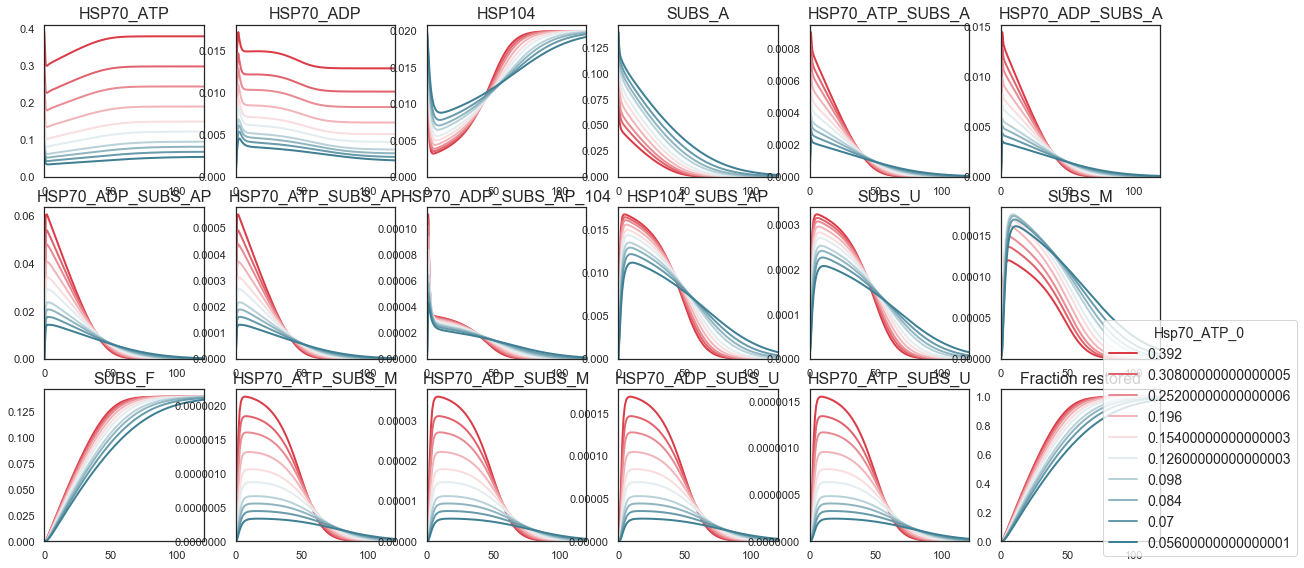

In [743]:
cols = sns.diverging_palette(10, 220, sep=10, n=10)
#sns.diverging_palette(240, 10, n = 8)

fig, axs = plt.subplots(nrows = 3, ncols = 6, figsize = (20,9.5))

for i in range(len(all_data)):
    axs[0, 0].plot(time, all_data[i][:,0], label = test_param[i], color = cols[i], linewidth = 2)
    axs[0, 0].set_title('HSP70_ATP', fontsize = 16)
    axs[0, 1].plot(time, all_data[i][:,1], label = test_param[i], color = cols[i], linewidth = 2)
    axs[0, 1].set_title('HSP70_ADP', fontsize = 16)    
    axs[0, 2].plot(time, all_data[i][:,2], label = test_param[i], color = cols[i], linewidth = 2)
    axs[0, 2].set_title('HSP104', fontsize = 16)        
    axs[0, 3].plot(time, all_data[i][:,3], label = test_param[i], color = cols[i], linewidth = 2)
    axs[0, 3].set_title('SUBS_A', fontsize = 16)
    axs[0, 4].plot(time, all_data[i][:,4], label = test_param[i], color = cols[i], linewidth = 2)
    axs[0, 4].set_title('HSP70_ATP_SUBS_A', fontsize = 16)    
    axs[0, 5].plot(time, all_data[i][:,5], label = test_param[i], color = cols[i], linewidth = 2)
    axs[0, 5].set_title('HSP70_ADP_SUBS_A', fontsize = 16)    
    axs[1, 0].plot(time, all_data[i][:,6], label = test_param[i], color = cols[i], linewidth = 2)
    axs[1, 0].set_title('HSP70_ADP_SUBS_AP', fontsize = 16)
    axs[1, 1].plot(time, all_data[i][:,7], label = test_param[i], color = cols[i], linewidth = 2)
    axs[1, 1].set_title('HSP70_ATP_SUBS_AP', fontsize = 16)    
    axs[1, 2].plot(time, all_data[i][:,8], label = test_param[i], color = cols[i], linewidth = 2)
    axs[1, 2].set_title('HSP70_ADP_SUBS_AP_104', fontsize = 16)        
    axs[1, 3].plot(time, all_data[i][:,9], label = test_param[i], color = cols[i], linewidth = 2)
    axs[1, 3].set_title('HSP104_SUBS_AP', fontsize = 16)
    axs[1, 4].plot(time, all_data[i][:,10], label = test_param[i], color = cols[i], linewidth = 2)
    axs[1, 4].set_title('SUBS_U', fontsize = 16)    
    axs[1, 5].plot(time, all_data[i][:,11], label = test_param[i], color = cols[i], linewidth = 2)
    axs[1, 5].set_title('SUBS_M', fontsize = 16)  
    axs[2, 0].plot(time, all_data[i][:,12], label = test_param[i], color = cols[i], linewidth = 2)
    axs[2, 0].set_title('SUBS_F', fontsize = 16)
    axs[2, 1].plot(time, all_data[i][:,13], label = test_param[i], color = cols[i], linewidth = 2)
    axs[2, 1].set_title('HSP70_ATP_SUBS_M', fontsize = 16)    
    axs[2, 2].plot(time, all_data[i][:,14], label = test_param[i], color = cols[i], linewidth = 2)
    axs[2, 2].set_title('HSP70_ADP_SUBS_M', fontsize = 16)        
    axs[2, 3].plot(time, all_data[i][:,15], label = test_param[i], color = cols[i], linewidth = 2)
    axs[2, 3].set_title('HSP70_ADP_SUBS_U', fontsize = 16)
    axs[2, 4].plot(time, all_data[i][:,16], label = test_param[i], color = cols[i], linewidth = 2)
    axs[2, 4].set_title('HSP70_ATP_SUBS_U', fontsize = 16)    
    axs[2, 5].plot(time, all_data[i][:,12]/SUBS_A_0, label = test_param[i], color = cols[i], linewidth = 2)
    axs[2, 5].set_title('Fraction restored', fontsize = 16) 
    axs[2, 5].set_ylim([0, 1.05])    

    
for ax in axs.flat:
    ax.set_xlim([0, 120])
    ax.set_ylim(bottom = 0)

axs[2,5].legend(loc='upper right', bbox_to_anchor=(1.9, 1.5), fontsize = 14, title = "Hsp70_ATP_0", title_fontsize = 14)     
  

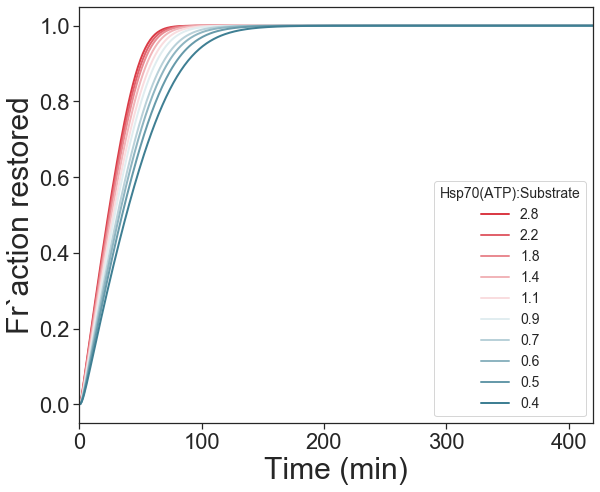

In [9]:
cols = sns.diverging_palette(10, 220, sep=10, n=10)

fig, ax = plt.subplots(figsize = (8.5,7))

for i in range(len(all_data)):
    ax.plot(time, all_data[i][:,12]/SUBS_A_0, label = round(test_param[i]/SUBS_A_0, 2), color = cols[i], linewidth = 2)
    
ax.set_title('', fontsize = 20, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 22)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 22)
ax.set_xlabel("Time (min)", fontsize = 30)
ax.set_ylabel("Fr`action restored", fontsize = 30)
ax.legend(loc='lower right', fontsize = 14, title = "Hsp70(ATP):Substrate", title_fontsize = 14)
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([0,420])

fig.tight_layout() 


### 1.5 Quantify the yield and maximal rate of dispersal
**Double check the calculation, esp sliding window analysis with someone else** <br>
Copy and paste the printed numbers in R

In [10]:
# Yield quantification
# Yield after 8 hours (480 min)

for i in range(len(all_data)):
    print(round(all_data[i][479,12]/SUBS_A_0,2), end = ", ")

# np.shape(all_data)

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [11]:
# Maximal rate quantification
# Sliding window analysis to find the maximal rate during the 8 hour reaction (480 min)

all_rates = []    

for j in range(len(all_data)):
    rates = []

    t_window = 2 # sliding time window in min; 
    pts_per_min = 1 # time points within 1 min
    
#     n_slide = int(len(time)/(t_window*pts_per_min))
    n_slide = len(time)-2

    for i in range(n_slide):
        rate = (all_data[j][(i)+t_window, 12] - all_data[j][(i), 12])/t_window
        rates.append(rate)
        
    all_rates.append(rates)
    

In [12]:
# Print maximal rate of dispersal

for i in range(len(all_rates)):
    print(round(max(all_rates[i][:]), 6), end=", ") # show up to 6 digits; unit in µM/min 
    

0.003224, 0.003146, 0.003067, 0.002952, 0.002822, 0.0027, 0.002526, 0.00241, 0.002263, 0.002074, 

### 1.6 Vary Hsp70(ATP) bindnig affinity 
Vary koff_ATP to change Kd of the substrate toward Hsp70(ATP). See if the increase in affinity is sufficient to generate a large dispersal efficiency difference. <br>
Repeat the analysis at 3 different K_fold values.

In [13]:
# Initialize relevant parameters

HSP70_ATP_0 = 1.0
SUBS_A_0 = 0.2 # Substrate concentration used in Pab1 vs. luciferase exp
koff_ATP = 2 * 60 
k_agg1 = 1
HSP104_0 = 0.1

In [14]:
k_fold = 0.001

test_param = np.logspace(start = -5, stop = 7.5, num = 40)

# Initialize starting Hsp70(ATP) and substrate concentrations. 
HSP70_ATP_0 = 1.0
SUBS_A_0 = 0.2


all_data_Kd_1 = [] 

for i, s in enumerate(test_param):
    koff_ATP = s
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0])
    
    data = odeint(model_naive_v3, zinit, time)
    all_data_Kd_1.append(data)

In [15]:
k_fold = 0.1

test_param = np.logspace(start = -5, stop = 7.5, num = 40)

# Initialize starting Hsp70(ATP) and substrate concentrations. 
HSP70_ATP_0 = 1.0
SUBS_A_0 = 0.2

all_data_Kd_2 = [] 

for i, s in enumerate(test_param):
    koff_ATP = s
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0])
    
    data = odeint(model_naive_v3, zinit, time)
    all_data_Kd_2.append(data)

In [16]:
k_fold = 10

test_param = np.logspace(start = -5, stop = 7.5, num = 40)

# Initialize starting Hsp70(ATP) and substrate concentrations. 
HSP70_ATP_0 = 1.0
SUBS_A_0 = 0.2

all_data_Kd_3 = [] 

for i, s in enumerate(test_param):
    koff_ATP = s
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0])
    
    data = odeint(model_naive_v3, zinit, time)
    all_data_Kd_3.append(data)

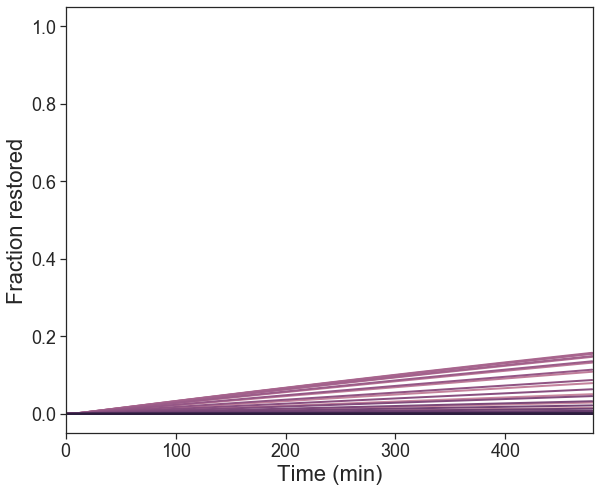

In [18]:
# Kinetic traces from all_data_Kd_1

cols = sns.cubehelix_palette(40, reverse = False)

fig, ax = plt.subplots(figsize = (8.5,7))

for i in range(len(all_data_Kd_1)):
    ax.plot(time, all_data_Kd_1[i][:,12]/SUBS_A_0, label = test_param[i], color = cols[i], linewidth = 2)
    
ax.set_title('', fontsize = 20, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 18)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 18)
ax.set_xlabel("Time (min)", fontsize = 22)
ax.set_ylabel("Fraction restored", fontsize = 22)
# ax.legend(loc='lower right', fontsize = 12, title_fontsize = 12)
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([0,480])

fig.tight_layout() 

In [19]:
summary_Kd_naive = pd.DataFrame(columns = ["Kd", "k_fold", "FracRestored"])

for i in range(len(all_data_Kd_1)):
    Frac_restored = all_data_Kd_1[i][119,12]/SUBS_A_0
    summary_Kd_naive.loc[i] = [test_param[i]/kon_ATP] + [0.001] + [Frac_restored]  

# for i in range(len(all_data_Kd_2)):
#     Frac_restored = all_data_Kd_2[i][119,12]/SUBS_A_0
#     summary_Kd_naive.loc[i + len(all_data_Kd_1)] = [test_param[i]/kon_ATP] + [0.1] + [Frac_restored]  
    
for i in range(len(all_data_Kd_3)):
    Frac_restored = all_data_Kd_3[i][119,12]/SUBS_A_0
    summary_Kd_naive.loc[i + len(all_data_Kd_1) + len(all_data_Kd_2)] = [test_param[i]/kon_ATP] + [10] + [Frac_restored]      
    
summary_Kd_naive["k_fold"] = summary_Kd_naive["k_fold"].astype("category")    
# summary_Kd_pathmatters

In [21]:
#summary_Kd_naive.to_csv(r'naive_Kd_summary.csv')

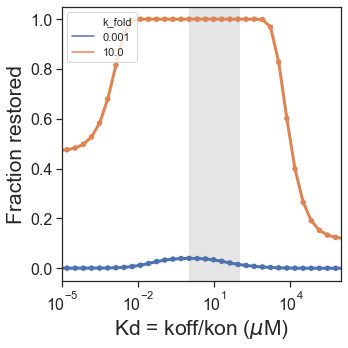

In [22]:
fig, ax = plt.subplots(figsize = (5, 5))

ax = sns.scatterplot(x = "Kd", y = "FracRestored", hue = "k_fold", data = summary_Kd_naive, s = 40, legend = False)
ax = sns.lineplot(x = "Kd", y = "FracRestored", hue = "k_fold", data = summary_Kd_naive, lw = 3)
ax.set_title('', fontsize = 16, loc = "left")
ax.set_xscale('log')
ax.set_xlim([1e-5, 1e6])
ax.set_ylim([-0.05,1.05])
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 16)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 16)
ax.set_xlabel("Kd = koff/kon ($\mu$M)", fontsize = 21)
ax.set_ylabel("Fraction restored", fontsize = 21)
ax.axvspan(1, 100, alpha=0.2, color='gray', lw = 0)
ax.legend(loc = "upper left")
# ax.get_legend().remove()

fig.tight_layout() 


**Conclusion:** 
The affinity has to increase or decrease by >3 orders of magnitude out of the experimentally observed range of affinity (grayed area) in order to produce the large efficiency difference. This is very unlikely. 

### 1.7 Vary partition factor (k_fold/(k_fold + k_agg1))
From the previous section, we saw that changing k_fold changes the shape of the yield plot dramatically. See how changing the relative partition of unfolded protein to folding vs. misfolding pathway change the yield. 


In [23]:
# Initialize relevant parameters

HSP70_ATP_0 = 1.0
SUBS_A_0 = 0.2 # substrate conc used in Pab1 vs luciferase exp
koff_ATP = 2 * 60 
k_agg1 = 1#100
HSP104_0 = 0.1

In [24]:
# Vary k_fold
# test_param = np.logspace(start = -3, stop = 6, num = 10)
test_param = [10, 1e-3]

all_data = [] 

for i, s in enumerate(test_param):
    k_fold = s
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0])
    data = odeint(model_naive_v3, zinit, time)
    all_data.append(data)
    

In [25]:
# cols = sns.cubehelix_palette(10, reverse = False)

# handpicked colors from the cols
cols = ["black", "#56B4E9"]

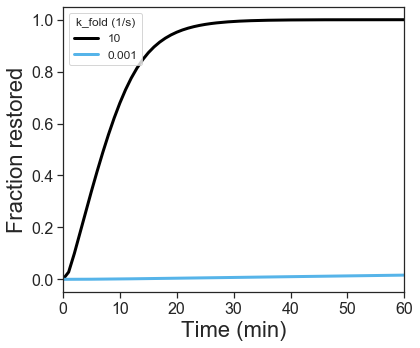

In [26]:
fig, ax = plt.subplots(figsize = (6,5))

for i in range(len(all_data)):
    ax.plot(time, all_data[i][:,12]/SUBS_A_0, label = test_param[i], color = cols[i], linewidth = 3)
    
ax.set_title('', fontsize = 16, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 16)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 16)
ax.set_xlabel("Time (min)", fontsize = 22)
ax.set_ylabel("Fraction restored", fontsize = 22)
ax.legend(loc='upper left', fontsize = 12, title = "k_fold (1/s)", title_fontsize = 12,
         labels = (test_param))
ax.set_xlim([0,60])
# ax.set_ylim([-0.05,1.05])
# ax.set_yscale("log")

fig.tight_layout() 

Print Yield at every time point. Copy and paste into R for plotting on top of experimental data:

In [26]:
pd.options.display.max_rows = 4000
#     print(round(max(all_rates[i][:]), 6), end=", ") # show up to 6 digits; unit in uM/min 

# print max rates
# all_data[0][i,12]; 
#             i = 0 for k_fold = 1000
#             i = 1 for k_fold = 0.1

for i in range(len(time)):
    print(round((all_data[1][i,12])/SUBS_A_0, 4), end=",") # show up to 6 digits; unit in uM/min 
    

0.0,0.0,0.0001,0.0001,0.0003,0.0004,0.0006,0.0008,0.001,0.0012,0.0014,0.0017,0.0019,0.0022,0.0025,0.0028,0.0031,0.0033,0.0036,0.0039,0.0042,0.0045,0.0048,0.0051,0.0054,0.0057,0.006,0.0063,0.0066,0.0069,0.0072,0.0075,0.0078,0.0081,0.0084,0.0087,0.009,0.0093,0.0096,0.0099,0.0102,0.0105,0.0108,0.0111,0.0114,0.0117,0.012,0.0123,0.0126,0.0129,0.0132,0.0135,0.0138,0.0141,0.0144,0.0147,0.015,0.0153,0.0156,0.0159,0.0162,0.0165,0.0168,0.0171,0.0174,0.0176,0.0179,0.0182,0.0185,0.0188,0.0191,0.0194,0.0197,0.02,0.0203,0.0206,0.0209,0.0212,0.0215,0.0218,0.0221,0.0224,0.0227,0.023,0.0233,0.0236,0.0239,0.0242,0.0245,0.0248,0.0251,0.0254,0.0256,0.0259,0.0262,0.0265,0.0268,0.0271,0.0274,0.0277,0.028,0.0283,0.0286,0.0289,0.0292,0.0295,0.0298,0.0301,0.0304,0.0307,0.031,0.0312,0.0315,0.0318,0.0321,0.0324,0.0327,0.033,0.0333,0.0336,0.0339,0.0342,0.0345,0.0348,0.0351,0.0353,0.0356,0.0359,0.0362,0.0365,0.0368,0.0371,0.0374,0.0377,0.038,0.0383,0.0386,0.0389,0.0391,0.0394,0.0397,0.04,0.0403,0.0406,0.0409,0.041

Vary k_fold and **plot yield as function of changing partition coefficient (k_fold/k_agg1).** <br>
k_agg1 is set at default value (10/s).

In [27]:
# Vary k_fold
test_param = np.logspace(start = -5, stop = 4, num = 40)

# Initial condensate/aggregate values can be changed here
SUBS_A_0 = 0.2

all_data_PartitionCoeff = [] 

for i, s in enumerate(test_param):
    k_fold = s
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0])
    
    data = odeint(model_naive_v3, zinit, time)
    all_data_PartitionCoeff.append(data)
    

In [28]:
summary_PC_naive = pd.DataFrame(columns = ["k_fold", "k_agg1", "FracRestored", "PartitionCoeff"])

for i in range(len(all_data_PartitionCoeff)):
    Frac_restored = all_data_PartitionCoeff[i][119,12]/SUBS_A_0
    summary_PC_naive.loc[i] = [test_param[i]] + [100] + [Frac_restored] + [test_param[i]/(test_param[i]+1)]# 10 = default k_agg1; double check
    
summary_PC_naive["k_agg1"] = summary_PC_naive["k_agg1"].astype("category")    
# summary_Kd_pathmatters

In [27]:
#summary_PC_naive.to_csv(r'naive_partitionCoeff_summary.csv')

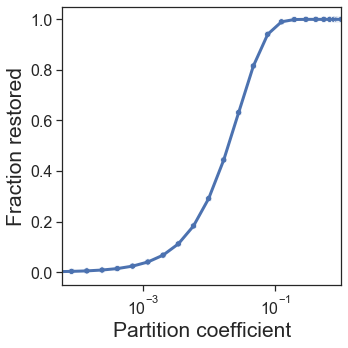

In [30]:
fig, ax = plt.subplots(figsize = (5, 5))

ax = sns.scatterplot(x = "PartitionCoeff", y = "FracRestored", hue = "k_agg1", data = summary_PC_naive, s = 40, legend = False)
ax = sns.lineplot(x = "PartitionCoeff", y = "FracRestored", hue = "k_agg1", data = summary_PC_naive, lw = 3)
ax.set_title('', fontsize = 16, loc = "left")
ax.set_xscale('log')
ax.set_xlim([6e-5, 1])
ax.set_ylim([-0.05,1.05])
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 16)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 16)
ax.set_xlabel("Partition coefficient", fontsize = 21)
ax.set_ylabel("Fraction restored", fontsize = 21)
# ax.axvspan(1e-3, 1e-2, alpha=0.2, color='gray', lw = 0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], title = "Misfolding rate\n(1/s)", loc = "lower right", fontsize = 16)
ax.get_legend().remove()

plt.rcParams['legend.title_fontsize'] = 'large'

fig.tight_layout() 


**Conclusion:** 
Orders of magnitude change in partition coefficient can account for almost all-or-nothing difference in dispersal yield (after 2 hr rxn). Note the partition coefficient is affected by both k_fold and k_agg1. 

### 1.8 Vary disaggregation rate (k_disagg)

In [31]:
# Initialize relevant parameters

HSP70_ATP_0 = 1.0
SUBS_A_0 = 0.2
koff_ATP = 2 * 60 
k_agg1 = 1
k_fold = 10

In [32]:
test_param = np.logspace(start = -6, stop = 2, num = 40)

# Initial condensate/aggregate values can be changed here
SUBS_A_0 = 0.2

all_data_disagg = [] 

for i, s in enumerate(test_param):
    k_disagg = s
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0])
    
    data = odeint(model_naive_v3, zinit, time)
    all_data_disagg.append(data)
    

(-0.05, 1.05)

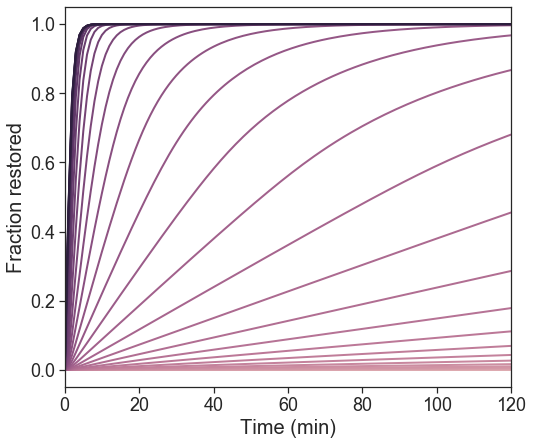

In [47]:
cols = sns.cubehelix_palette(40, reverse = False)

fig, ax = plt.subplots(figsize = (8,7))

for i in range(len(all_data_disagg)):
    ax.plot(time, all_data_disagg[i][:,12]/SUBS_A_0, label = test_param[i], color = cols[i], linewidth = 2)
    
# ax.set_title('[Condensate] = 30; [Hsp70(ATP)] = 30\nk_fold = 1000', fontsize = 20, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 18)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 18)
ax.set_xlabel("Time (min)", fontsize = 20)
ax.set_ylabel("Fraction restored", fontsize = 20)
# ax.legend(loc='upper right', bbox_to_anchor=(1.4,1), fontsize = 16, title = "k_disagg", title_fontsize = 18,
#          labels = test_param)
ax.set_xlim([0,120])
ax.set_ylim([-0.05,1.05])

In [33]:
summary_kdisagg_naive = pd.DataFrame(columns = ["kdisagg", "FracRestored"])

for i in range(len(all_data_disagg)):
    Frac_restored = all_data_disagg[i][119,12]/SUBS_A_0
    summary_kdisagg_naive.loc[i] = [test_param[i]] + [Frac_restored] 
    

In [781]:
#summary_kdisagg_naive.to_csv(r'naive_kdisagg_summary.csv')

Text(0, 0.5, 'Fraction restored')

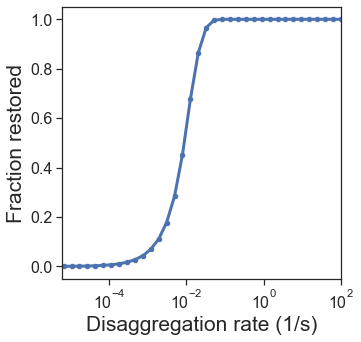

In [34]:
fig, ax = plt.subplots(figsize = (5, 5))

ax = sns.scatterplot(x = "kdisagg", y = "FracRestored" , data = summary_kdisagg_naive, s = 40, legend = False)
ax = sns.lineplot(x = "kdisagg", y = "FracRestored", data = summary_kdisagg_naive, lw = 3)
# ax.plot(test_param, summary_kdisagg, "ko")
ax.set_xscale('log')
ax.set_ylim([-0.05, 1.05]) 
# ax.set_xlim([1e-6, 1e4])
ax.set_xlim([6e-6, 1e2])
# ax.set_title('[Condensate] = 30; [Hsp70(ATP)] = 30\nk_fold = 1000, k_disagg1 = 1, t = 300 min', fontsize = 16, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 16)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 16)
ax.set_xlabel("Disaggregation rate (1/s)", fontsize = 21)
ax.set_ylabel("Fraction restored", fontsize = 21)
# ax.axvspan(0.05, 0.5, alpha=0.2, color'gray', lw = 0)


**Conclusion:** <br>
Orders of magnitude change in disaggregation can also account for almost all-or-nothing difference in dispersal yield (after 2 hr rxn). Disaggregation rate or effective disaggregation rate may change if Hsp104 is having harder time processing a substrate but remain bound to the substrate (i.e. longer residence time) or if Hsp104 has lower success rate (i.e. suceeds to process a substrate on average 1/n times). 

### 2.0 Cooperative model (i.e. multiple Hsp70 binding model)
This model differs from the naive model in that it requires two Hsp70 binding to a substrate in order to engage with Hsp104 and proceed to disaggregation. Two Hsp70 binding was used to qualitatively illustrate the effect of having 1 vs. more than 1 Hsp70 as a requirement on the disaggregation system's sensitivity to Hsp70.<br>


<img src="model_cooperative.png" alt="full" width="900" style = "float: center"/>


The binding affinity of the second Hsp70(ATP) is adjusted to be 1 order of magnitude lower than the first Hsp70(ATP) to account for excluded volume effects (source: Wentink et al. Nature (2020)).

### 2.1 Set initial concentration and time interval
Concentrations are in **µM** <br>
Time in **min**
<br><br>
Rate parameters remain the same as used in the native model, except kon_ATP for the second Hsp70(ATP) binding:

In [180]:
kon_ATP2 = 0.1*kon_ATP
k_disagg = 0.2

In [181]:
HSP70_ATP_0 = 1
HSP70_ADP_0 = 0
HSP104_0 = 0.02
SUBS_A_0 = 0.143 # Substrate aggregated (e.g. condensed Pab1, aggregated luciferase)

HSP70_ATP_SUBS_A_0 = 0
HSP70_ADP_SUBS_A_0 = 0
HSP70_ADP_SUBS_AP_0 = 0 # AP = Substrate Aggregated_Primed
HSP70_ATP_SUBS_AP_0 = 0
HSP70_ADP_ADP_SUBS_AP_104_0 = 0 # modified for the cooperative model
HSP104_SUBS_AP_0 = 0

SUBS_U_0 = 0 # Substrate Unfolded
SUBS_M_0 = 0 # Substrate Misfolded
SUBS_F_0 = 0 # Substrate Folded
HSP70_ATP_SUBS_M_0 = 0
HSP70_ADP_SUBS_M_0 = 0
HSP70_ADP_SUBS_U_0 = 0
HSP70_ATP_SUBS_U_0 = 0

HSP70_ATP_ADP_SUBS_AP_0 = 0 # added for the cooperative model
HSP70_ADP_ADP_SUBS_AP_0 = 0 # added for the cooperative model

z = []

time = np.arange(0, 480, 1)

zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0, 
                  HSP70_ATP_ADP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_0])


### 2.2 Define the model

In [182]:
def model_double70_v3(z, t):
    """
    Function used with odeint to simulate disaggregation by chaperones.
    Revised the naive_v3 and double70_v2 (12/29/2020). 
    """
    
    ###
    # z is a list of the initial concentrations 
    ###
    HSP70_ATP = z[0]
    HSP70_ADP = z[1]
    HSP104 = z[2]
    SUBS_A = z[3] 

    HSP70_ATP_SUBS_A = z[4]
    HSP70_ADP_SUBS_A = z[5]
    HSP70_ADP_SUBS_AP = z[6]
    HSP70_ATP_SUBS_AP = z[7]
    HSP70_ADP_ADP_SUBS_AP_104 = z[8]
    HSP104_SUBS_AP = z[9]

    SUBS_U = z[10]
    SUBS_M = z[11]
    SUBS_F = z[12]
    HSP70_ATP_SUBS_M = z[13]
    HSP70_ADP_SUBS_M = z[14]
    HSP70_ADP_SUBS_U = z[15]
    HSP70_ATP_SUBS_U = z[16]
    
    HSP70_ATP_ADP_SUBS_AP = z[17] # added for the cooperative model
    HSP70_ADP_ADP_SUBS_AP = z[18] # added for the cooperative model
    
    ###
    # equations describing the change in concentration of a specie per time
    ###
    
    dHSP70_ATPdt = kDT*HSP70_ADP + koff_ATP*(HSP70_ATP_SUBS_AP + HSP70_ATP_SUBS_A + HSP70_ATP_SUBS_M + HSP70_ATP_SUBS_U + HSP70_ATP_ADP_SUBS_AP) - HSP70_ATP*(kon_ATP*(SUBS_A + SUBS_M) + (kTD + kh) + (kon_ATP2*HSP70_ADP_SUBS_AP))

    dHSP70_ADPdt = (kTD + kh)*HSP70_ATP + koff_ADP*(HSP70_ADP_SUBS_AP + HSP70_ADP_SUBS_U) + 2*koff_ADP_104*HSP70_ADP_ADP_SUBS_AP_104 - HSP70_ADP*(kDT + kon_ADP*(SUBS_A + SUBS_U))

    dHSP104dt = koff_104*HSP70_ADP_ADP_SUBS_AP_104 + k_disagg*HSP104_SUBS_AP - HSP104*kon_104*HSP70_ADP_ADP_SUBS_AP

    dSUBS_Adt = k_agg2*SUBS_M + koff_ATP*(HSP70_ATP_SUBS_A + HSP70_ATP_SUBS_AP) + koff_ADP*HSP70_ADP_SUBS_AP - SUBS_A*((kon_ATP*HSP70_ATP) + (kon_ADP*HSP70_ADP))      

    dHSP70_ATP_SUBS_Adt = kon_ATP*HSP70_ATP*SUBS_A + kDT_s*HSP70_ADP_SUBS_A - HSP70_ATP_SUBS_A*(koff_ATP + kTD_s + kh_s)
  
    
    dHSP70_ADP_SUBS_Adt = (kTD_s + kh_s)*HSP70_ATP_SUBS_A + k_deprime*HSP70_ADP_SUBS_AP - HSP70_ADP_SUBS_A*(kDT_s + k_prime)
   
    dHSP70_ADP_SUBS_APdt = k_prime*HSP70_ADP_SUBS_A + kTD_s*HSP70_ATP_SUBS_AP + koff_ATP*HSP70_ATP_ADP_SUBS_AP + kon_ADP*HSP70_ADP*SUBS_A - HSP70_ADP_SUBS_AP*(k_deprime + kDT_s + koff_ADP + (kon_ATP2*HSP70_ATP))
   
    dHSP70_ATP_SUBS_APdt = kDT_s*HSP70_ADP_SUBS_AP - HSP70_ATP_SUBS_AP*(koff_ATP + kTD_s)
 
    dHSP70_ADP_ADP_SUBS_AP_104dt = kon_104*HSP70_ADP_ADP_SUBS_AP*HSP104 - HSP70_ADP_ADP_SUBS_AP_104*(koff_104 + koff_ADP_104)
      
    dHSP104_SUBS_APdt = koff_ADP_104*HSP70_ADP_ADP_SUBS_AP_104 - HSP104_SUBS_AP*k_disagg
 
    dSUBS_Udt = k_unfold*SUBS_F + kr_agg1*SUBS_M + k_disagg*HSP104_SUBS_AP + koff_ATP*HSP70_ATP_SUBS_U + koff_ADP*HSP70_ADP_SUBS_U - SUBS_U*(k_fold + k_agg1 + (kon_ADP*HSP70_ADP))
    
    dSUBS_Mdt = k_agg1*SUBS_U + koff_ATP*HSP70_ATP_SUBS_M - SUBS_M*(kr_agg1 + (k_agg2) + (kon_ATP*HSP70_ATP))
    
    dSUBS_Fdt = k_fold*SUBS_U - SUBS_F*k_unfold
    
    dHSP70_ATP_SUBS_Mdt = kon_ATP*SUBS_M*HSP70_ATP + kDT_s*HSP70_ADP_SUBS_M - HSP70_ATP_SUBS_M*(koff_ATP + (kTD_s + kh_s))  
    
    dHSP70_ADP_SUBS_Mdt = (kTD_s + kh_s)*HSP70_ATP_SUBS_M + k_deprime*HSP70_ADP_SUBS_U - HSP70_ADP_SUBS_M*(kDT_s + k_prime)
    
    dHSP70_ADP_SUBS_Udt = k_prime*HSP70_ADP_SUBS_M + kTD_s*HSP70_ATP_SUBS_U + kon_ADP*HSP70_ADP*SUBS_U - HSP70_ADP_SUBS_U*(k_deprime + kDT_s + koff_ADP)
    
    dHSP70_ATP_SUBS_Udt = kDT_s*HSP70_ADP_SUBS_U - HSP70_ATP_SUBS_U*(koff_ATP + kTD_s)
 

    dHSP70_ATP_ADP_SUBS_APdt = kon_ATP2*HSP70_ATP*HSP70_ADP_SUBS_AP + (2*kDT_s)*HSP70_ADP_ADP_SUBS_AP - HSP70_ATP_ADP_SUBS_AP*(koff_ATP + (kTD_s + kh_s))
   
    dHSP70_ADP_ADP_SUBS_APdt = (kTD_s + kh_s)*HSP70_ATP_ADP_SUBS_AP + koff_104*HSP70_ADP_ADP_SUBS_AP_104 - HSP70_ADP_ADP_SUBS_AP*((2*kDT_s) + (kon_104*HSP104))


    return(np.array([dHSP70_ATPdt, dHSP70_ADPdt, dHSP104dt, dSUBS_Adt, dHSP70_ATP_SUBS_Adt, 
                     dHSP70_ADP_SUBS_Adt, dHSP70_ADP_SUBS_APdt, dHSP70_ATP_SUBS_APdt, dHSP70_ADP_ADP_SUBS_AP_104dt, 
                     dHSP104_SUBS_APdt, dSUBS_Udt, dSUBS_Mdt, dSUBS_Fdt, dHSP70_ATP_SUBS_Mdt, 
                     dHSP70_ADP_SUBS_Mdt, dHSP70_ADP_SUBS_Udt, dHSP70_ATP_SUBS_Udt, 
                     dHSP70_ATP_ADP_SUBS_APdt, dHSP70_ADP_ADP_SUBS_APdt]))
    


### 2.3 Plot kinetic profiles of all species in the model

In [183]:
test_param = [2.8, 2.2, 1.8, 1.4, 1.1, 0.90, 0.70, 0.60, 0.50, 0.40]

In [184]:
# Vary [HSP70_ATP_0]
# test_param = [0.28, 0.22, 0.18, 0.14, 0.11, 0.090, 0.070, 0.060, 0.050, 0.040]
test_param = [i * SUBS_A_0 for i in test_param]

all_data = [] 

for i, s in enumerate(test_param):
    HSP70_ATP_0 = s
#     HSP104_0 = s
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0, 
                  HSP70_ATP_ADP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_0])
    
    data = odeint(model_double70_v3, zinit, time)
    all_data.append(data)
    

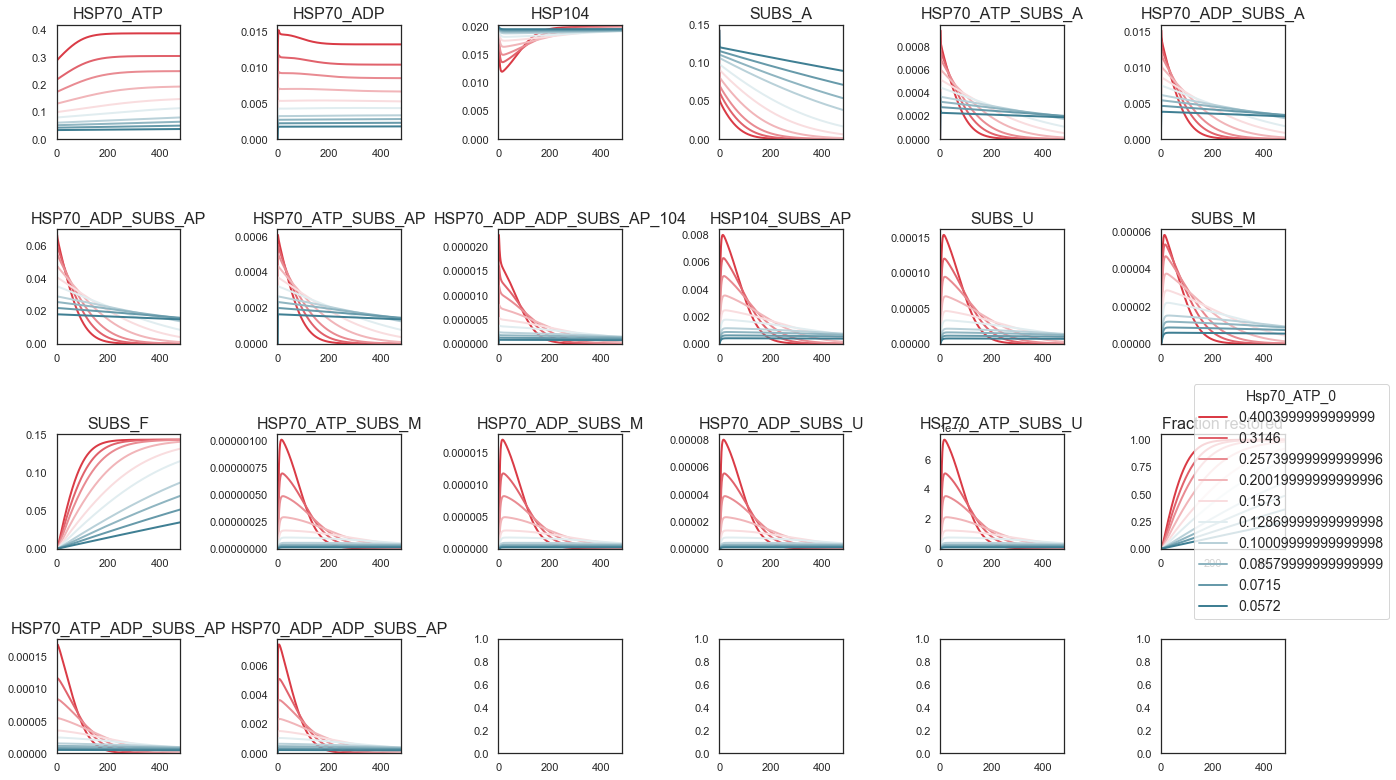

In [40]:
cols = sns.diverging_palette(10, 220, sep=10, n=10)
#sns.diverging_palette(240, 10, n = 8)

fig, axs = plt.subplots(nrows = 4, ncols = 6, figsize = (20,11))

for i in range(len(all_data)):
    axs[0, 0].plot(time, all_data[i][:,0], label = test_param[i], color = cols[i], linewidth = 2)
    axs[0, 0].set_title('HSP70_ATP', fontsize = 16)
    axs[0, 1].plot(time, all_data[i][:,1], label = test_param[i], color = cols[i], linewidth = 2)
    axs[0, 1].set_title('HSP70_ADP', fontsize = 16)    
    axs[0, 2].plot(time, all_data[i][:,2], label = test_param[i], color = cols[i], linewidth = 2)
    axs[0, 2].set_title('HSP104', fontsize = 16)        
    axs[0, 3].plot(time, all_data[i][:,3], label = test_param[i], color = cols[i], linewidth = 2)
    axs[0, 3].set_title('SUBS_A', fontsize = 16)
    axs[0, 4].plot(time, all_data[i][:,4], label = test_param[i], color = cols[i], linewidth = 2)
    axs[0, 4].set_title('HSP70_ATP_SUBS_A', fontsize = 16)    
    axs[0, 5].plot(time, all_data[i][:,5], label = test_param[i], color = cols[i], linewidth = 2)
    axs[0, 5].set_title('HSP70_ADP_SUBS_A', fontsize = 16)    
    axs[1, 0].plot(time, all_data[i][:,6], label = test_param[i], color = cols[i], linewidth = 2)
    axs[1, 0].set_title('HSP70_ADP_SUBS_AP', fontsize = 16)
    axs[1, 1].plot(time, all_data[i][:,7], label = test_param[i], color = cols[i], linewidth = 2)
    axs[1, 1].set_title('HSP70_ATP_SUBS_AP', fontsize = 16)    
    axs[1, 2].plot(time, all_data[i][:,8], label = test_param[i], color = cols[i], linewidth = 2)
    axs[1, 2].set_title('HSP70_ADP_ADP_SUBS_AP_104', fontsize = 16)        
    axs[1, 3].plot(time, all_data[i][:,9], label = test_param[i], color = cols[i], linewidth = 2)
    axs[1, 3].set_title('HSP104_SUBS_AP', fontsize = 16)
    axs[1, 4].plot(time, all_data[i][:,10], label = test_param[i], color = cols[i], linewidth = 2)
    axs[1, 4].set_title('SUBS_U', fontsize = 16)    
    axs[1, 5].plot(time, all_data[i][:,11], label = test_param[i], color = cols[i], linewidth = 2)
    axs[1, 5].set_title('SUBS_M', fontsize = 16)  
    axs[2, 0].plot(time, all_data[i][:,12], label = test_param[i], color = cols[i], linewidth = 2)
    axs[2, 0].set_title('SUBS_F', fontsize = 16)
    axs[2, 1].plot(time, all_data[i][:,13], label = test_param[i], color = cols[i], linewidth = 2)
    axs[2, 1].set_title('HSP70_ATP_SUBS_M', fontsize = 16)    
    axs[2, 2].plot(time, all_data[i][:,14], label = test_param[i], color = cols[i], linewidth = 2)
    axs[2, 2].set_title('HSP70_ADP_SUBS_M', fontsize = 16)        
    axs[2, 3].plot(time, all_data[i][:,15], label = test_param[i], color = cols[i], linewidth = 2)
    axs[2, 3].set_title('HSP70_ADP_SUBS_U', fontsize = 16)
    axs[2, 4].plot(time, all_data[i][:,16], label = test_param[i], color = cols[i], linewidth = 2)
    axs[2, 4].set_title('HSP70_ATP_SUBS_U', fontsize = 16)    
    axs[2, 5].plot(time, all_data[i][:,12]/SUBS_A_0, label = test_param[i], color = cols[i], linewidth = 2)
    axs[2, 5].set_title('Fraction restored', fontsize = 16) 
    axs[2, 5].set_ylim([0, 1.05])    
    axs[3, 0].plot(time, all_data[i][:,17], label = test_param[i], color = cols[i], linewidth = 2)
    axs[3, 0].set_title('HSP70_ATP_ADP_SUBS_AP', fontsize = 16)
    axs[3, 1].plot(time, all_data[i][:,18], label = test_param[i], color = cols[i], linewidth = 2)
    axs[3, 1].set_title('HSP70_ADP_ADP_SUBS_AP', fontsize = 16)     

    
for ax in axs.flat:
    ax.set_xlim([0, 480])
    ax.set_ylim(bottom = 0)

axs[2,5].legend(loc='upper right', bbox_to_anchor=(1.9, 1.5), fontsize = 14, title = "Hsp70_ATP_0", title_fontsize = 14)     
    
fig.tight_layout() 
# fig.savefig('NaiveV2_CS0_AU30.pdf')
# fig.savefig('NaiveV2_CS30_AU0.pdf')
# fig.savefig('NaiveV2_CS30_AU30.pdf')



In [185]:
cols = sns.diverging_palette(10, 220, sep=10, n=10)
cols.as_hex()

['#da3b46',
 '#e1626c',
 '#e98b92',
 '#f1b5b9',
 '#f9dddf',
 '#e1edf0',
 '#b9d1d9',
 '#8fb5c1',
 '#679aaa',
 '#3f7f93']

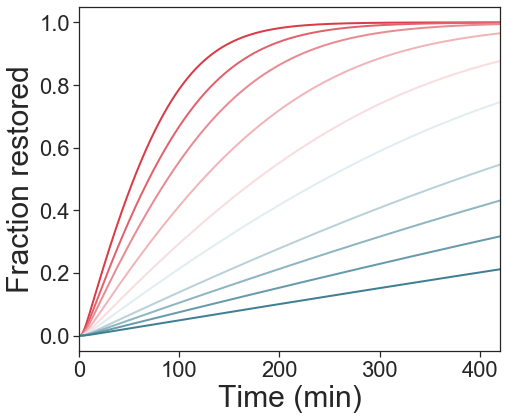

In [43]:
cols = sns.diverging_palette(10, 220, sep=10, n=10)

fig, ax = plt.subplots(figsize = (7.2,6))

for i in range(len(all_data)):
    ax.plot(time, all_data[i][:,12]/SUBS_A_0, label = round(test_param[i]/SUBS_A_0, 2), color = cols[i], linewidth = 2)
    
ax.set_title('', fontsize = 20, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 22)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 22)
ax.set_xlabel("Time (min)", fontsize = 30)
ax.set_ylabel("Fraction restored", fontsize = 30)
ax.legend(loc='lower right', fontsize = 14, title = "Hsp70(ATP):Substrate", title_fontsize = 14)
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([0,420])
ax.get_legend().remove()

fig.tight_layout() 


In [44]:
# Export csv
df_titrate_70 = pd.DataFrame({'chap_to_sub':[], 
                              'FracRestored':[]})


for i in range(len(all_data)):
    temp = pd.DataFrame({'chap_to_sub': round(test_param[i]/SUBS_A_0, 2),
                         'FracRestored': all_data[i][:,12]/SUBS_A_0})
    df_titrate_70 = pd.concat([df_titrate_70,temp])
    

# print(df_titrate_70)
#df_titrate_70.to_csv(r'py_titrate_8hr_ssa2.csv')

### 2.4 Quantify the yield and maximal rate of dispersal
**Double check the calculation, esp sliding window analysis with someone else** <br>
Copy and paste the printed numbers in R

In [45]:
# Yield quantification
# Yield after 8 hours (480 min)

for i in range(len(all_data)):
    print(round(all_data[i][479,12]/SUBS_A_0,2), end = ", ")

# np.shape(all_data)

1.0, 1.0, 1.0, 0.98, 0.92, 0.8, 0.61, 0.48, 0.36, 0.24, 

In [46]:
# Maximal rate quantification
# Sliding window analysis to find the maximal rate during the 8 hour reaction (480 min)

all_rates = []    

for j in range(len(all_data)):
    rates = []

    t_window = 2 # sliding time window in min; 
    pts_per_min = 1 # time points within 1 min
    
#     n_slide = int(len(time)/(t_window*pts_per_min))
    n_slide = len(time) - 2

    for i in range(n_slide):
        rate = (all_data[j][(i)+t_window, 12] - all_data[j][(i), 12])/t_window
        rates.append(rate)
        
    all_rates.append(rates)
    

In [47]:
# Print maximal rate of dispersal

for i in range(len(all_rates)):
    print(round(max(all_rates[i][:]), 6), end=", ") # show up to 6 digits; unit in µM/min 


0.001535, 0.001201, 0.000945, 0.00067, 0.000462, 0.000331, 0.000213, 0.000161, 0.000114, 7.5e-05, 

### 2.5 Vary Hsp70(ATP) bindnig affinity 
Vary koff_ATP to change Kd of the substrate toward Hsp70(ATP). See if the increase in affinity is sufficient to generate a large dispersal efficiency difference. <br>
Repeat the analysis at 3 different K_fold values.

In [48]:
k_fold = 0.001

test_param = np.logspace(start = -5, stop = 9, num = 40)

# Initialize starting Hsp70(ATP) and substrate concentrations. 
HSP70_ATP_0 = 1.0
SUBS_A_0 = 0.2


all_data_Kd_1db = [] 

for i, s in enumerate(test_param):
    koff_ATP = s
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0, 
                  HSP70_ATP_ADP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_0])
    
    data = odeint(model_double70_v3, zinit, time)
    all_data_Kd_1db.append(data)

/Users/haneulyoo/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [49]:
k_fold = 0.1

test_param = np.logspace(start = -5, stop = 9, num = 40)

# Initialize starting Hsp70(ATP) and substrate concentrations. 
HSP70_ATP_0 = 1.0
SUBS_A_0 = 0.2

all_data_Kd_2db = [] 

for i, s in enumerate(test_param):
    koff_ATP = s
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0, 
                  HSP70_ATP_ADP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_0])
    
    data = odeint(model_double70_v3, zinit, time)
    all_data_Kd_2db.append(data)

In [50]:
k_fold = 10

test_param = np.logspace(start = -5, stop = 9, num = 40)

# Initialize starting Hsp70(ATP) and substrate concentrations. 
HSP70_ATP_0 = 1.0
SUBS_A_0 = 0.2

all_data_Kd_3db = [] 

for i, s in enumerate(test_param):
    koff_ATP = s
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0, 
                  HSP70_ATP_ADP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_0])
    
    data = odeint(model_double70_v3, zinit, time)
    all_data_Kd_3db.append(data)

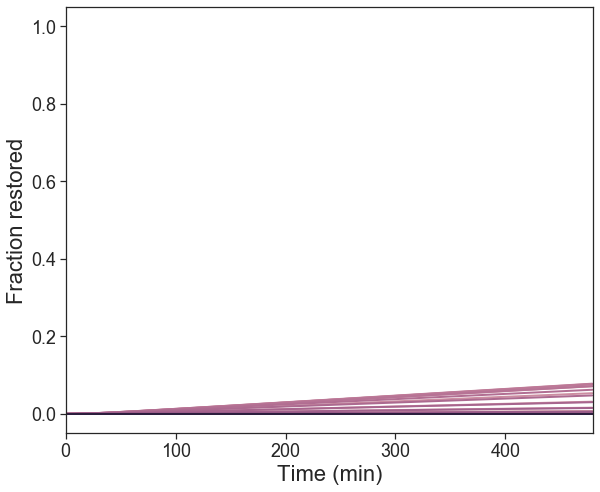

In [51]:
# Kinetic traces from all_data_Kd_1

cols = sns.cubehelix_palette(40, reverse = False)

fig, ax = plt.subplots(figsize = (8.5,7))

for i in range(len(all_data_Kd_1db)):
    ax.plot(time, all_data_Kd_1db[i][:,12]/SUBS_A_0, label = test_param[i], color = cols[i], linewidth = 2)
    
ax.set_title('', fontsize = 20, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 18)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 18)
ax.set_xlabel("Time (min)", fontsize = 22)
ax.set_ylabel("Fraction restored", fontsize = 22)
# ax.legend(loc='lower right', fontsize = 12, title_fontsize = 12)
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([0,480])

fig.tight_layout() 

In [52]:
summary_Kd_db = pd.DataFrame(columns = ["Kd", "k_fold", "FracRestored"])

for i in range(len(all_data_Kd_1db)):
    Frac_restored = all_data_Kd_1db[i][119,12]/SUBS_A_0
    summary_Kd_db.loc[i] = [test_param[i]/kon_ATP] + [0.001] + [Frac_restored]  

# for i in range(len(all_data_Kd_2db)):
#     Frac_restored = all_data_Kd_2db[i][119,12]/SUBS_A_0
#     summary_Kd_db.loc[i + len(all_data_Kd_1db)] = [test_param[i]/kon_ATP] + [0.1] + [Frac_restored]  
    
for i in range(len(all_data_Kd_3db)):
    Frac_restored = all_data_Kd_3db[i][119,12]/SUBS_A_0
    summary_Kd_db.loc[i + len(all_data_Kd_1db) + len(all_data_Kd_2db)] = [test_param[i]/kon_ATP] + [10] + [Frac_restored]      
    
summary_Kd_db["k_fold"] = summary_Kd_db["k_fold"].astype("category")    


In [800]:
#summary_Kd_db.to_csv(r'double_Kd_summary.csv')

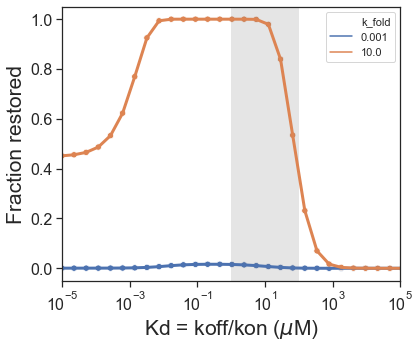

In [53]:
fig, ax = plt.subplots(figsize = (6, 5))

ax = sns.scatterplot(x = "Kd", y = "FracRestored", hue = "k_fold", data = summary_Kd_db, s = 40, legend = False)
ax = sns.lineplot(x = "Kd", y = "FracRestored", hue = "k_fold", data = summary_Kd_db, lw = 3)
ax.set_title('', fontsize = 16, loc = "left")
ax.set_xscale('log')
ax.set_xlim([1e-5, 1e5])
ax.set_ylim([-0.05,1.05])
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 16)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 16)
ax.set_xlabel("Kd = koff/kon ($\mu$M)", fontsize = 21)
ax.set_ylabel("Fraction restored", fontsize = 21)
ax.axvspan(1, 100, alpha=0.2, color='gray', lw = 0)
ax.legend(loc = "upper right")
# ax.get_legend().remove()

fig.tight_layout() 


**Conclusion:** 
The requirement for the second Hsp70 binding, which binds with an order of magnitude lower affinity, made the system more sensitive to Kd than the native model. About or greater than 2 orders of magnitude difference in affinity can account for large difference in dispersal efficiency in the cooperative model. Whether this much variation in affinity is at play *in vivo* and/or *in vitro* is unclear.  

### 2.6 Vary partition coefficient (k_fold/(k_fold+k_agg1))
From the previous section, we saw that changing k_fold changes the shape of the yield plot dramatically. See how changing the relative partition of unfolded protein to folding vs. misfolding pathway change the yield. 

In [54]:
# Initialize relevant parameters

HSP70_ATP_0 = 1.0
SUBS_A_0 = 0.2
koff_ATP = 2 * 60 
k_agg1 = 1
k_fold = 1e1
HSP104_0 = 0.1

In [55]:
# Vary k_fold
# test_param = np.logspace(start = -3, stop = 6, num = 10)
test_param = [10, 1e-3]


all_data = [] 

for i, s in enumerate(test_param):
    k_fold = s
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0, 
                  HSP70_ATP_ADP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_0])
    data = odeint(model_double70_v3, zinit, time)
    all_data.append(data)
    

In [56]:
# cols = sns.cubehelix_palette(10, reverse = False)

# handpicked colors from the cols
cols = ["black", "#56B4E9"]

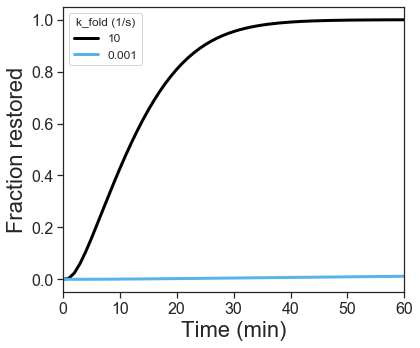

In [57]:
fig, ax = plt.subplots(figsize = (6,5))

for i in range(len(all_data)):
    ax.plot(time, all_data[i][:,12]/SUBS_A_0, label = test_param[i], color = cols[i], linewidth = 3)
    
ax.set_title('', fontsize = 16, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 16)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 16)
ax.set_xlabel("Time (min)", fontsize = 22)
ax.set_ylabel("Fraction restored", fontsize = 22)
ax.legend(loc='upper left', fontsize = 12, title = "k_fold (1/s)", title_fontsize = 12,
         labels = (test_param))
ax.set_xlim([0,60])
# ax.set_ylim([-0.05,1.05])
# ax.set_yscale("log")

fig.tight_layout() 

Print Yield at every time point. Copy and paste into R for plotting on top of experimental data:

In [58]:
pd.options.display.max_rows = 4000
#     print(round(max(all_rates[i][:]), 6), end=", ") # show up to 6 digits; unit in uM/min 

# print max rates
# all_data[0][i,12]; 
#             i = 0 for k_fold = 100
#             i = 1 for k_fold = 0.01

for i in range(len(time)):
    print(round((all_data[1][i,12])/SUBS_A_0, 4), end=",") # show up to 6 digits; unit in uM/min 
    

0.0,0.0,0.0,0.0,0.0001,0.0002,0.0002,0.0004,0.0005,0.0006,0.0008,0.0009,0.0011,0.0013,0.0015,0.0017,0.0019,0.0021,0.0023,0.0025,0.0027,0.0029,0.0032,0.0034,0.0036,0.0038,0.0041,0.0043,0.0045,0.0047,0.005,0.0052,0.0054,0.0056,0.0059,0.0061,0.0063,0.0065,0.0068,0.007,0.0072,0.0075,0.0077,0.0079,0.0081,0.0084,0.0086,0.0088,0.009,0.0093,0.0095,0.0097,0.01,0.0102,0.0104,0.0106,0.0109,0.0111,0.0113,0.0115,0.0118,0.012,0.0122,0.0124,0.0127,0.0129,0.0131,0.0133,0.0136,0.0138,0.014,0.0143,0.0145,0.0147,0.0149,0.0152,0.0154,0.0156,0.0158,0.0161,0.0163,0.0165,0.0167,0.017,0.0172,0.0174,0.0176,0.0179,0.0181,0.0183,0.0185,0.0188,0.019,0.0192,0.0194,0.0197,0.0199,0.0201,0.0203,0.0206,0.0208,0.021,0.0212,0.0215,0.0217,0.0219,0.0221,0.0224,0.0226,0.0228,0.023,0.0233,0.0235,0.0237,0.0239,0.0242,0.0244,0.0246,0.0248,0.0251,0.0253,0.0255,0.0257,0.0259,0.0262,0.0264,0.0266,0.0268,0.0271,0.0273,0.0275,0.0277,0.028,0.0282,0.0284,0.0286,0.0289,0.0291,0.0293,0.0295,0.0297,0.03,0.0302,0.0304,0.0306,0.0309,0.03

Vary k_fold and **plot yield as function of changing partition coefficient (k_fold/k_agg1).** <br>
k_agg1 is set at default value (10/s).

In [59]:
# Vary k_fold
test_param = np.logspace(start = -5, stop = 4, num = 40)

# Initial condensate/aggregate values can be changed here
SUBS_A_0 = 0.2

all_data_PartitionCoeff = [] 

for i, s in enumerate(test_param):
    k_fold = s
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0, 
                  HSP70_ATP_ADP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_0])
    
    data = odeint(model_double70_v3, zinit, time)
    all_data_PartitionCoeff.append(data)
    

In [60]:
summary_PC_db = pd.DataFrame(columns = ["k_fold", "k_agg1", "FracRestored", "PartitionCoeff"])

for i in range(len(all_data_PartitionCoeff)):
    Frac_restored = all_data_PartitionCoeff[i][119,12]/SUBS_A_0
    summary_PC_db.loc[i] = [test_param[i]] + [1] + [Frac_restored] + [test_param[i]/(test_param[i] + 1)]# 10 = default k_agg1; double check
    
summary_PC_db["k_agg1"] = summary_PC_db["k_agg1"].astype("category")    


In [60]:
#summary_PC_db.to_csv(r'double_partitionCoeff_summary.csv')

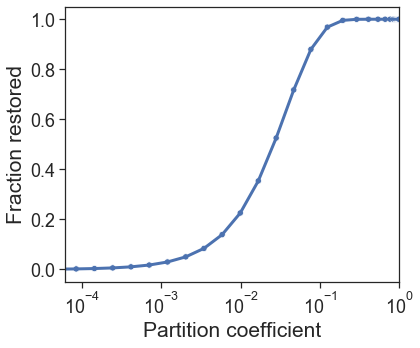

In [61]:
fig, ax = plt.subplots(figsize = (6, 5))

ax = sns.scatterplot(x = "PartitionCoeff", y = "FracRestored", hue = "k_agg1", data = summary_PC_db, s = 40, legend = False)
ax = sns.lineplot(x = "PartitionCoeff", y = "FracRestored", hue = "k_agg1", data = summary_PC_db, lw = 3)
ax.set_title('', fontsize = 16, loc = "left")
ax.set_xscale('log')
ax.set_xlim([6e-5, 1])
ax.set_ylim([-0.05,1.05])
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 18)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 18)
ax.set_xlabel("Partition coefficient", fontsize = 21)
ax.set_ylabel("Fraction restored", fontsize = 21)
# ax.axvspan(1e-3, 1e-2, alpha=0.2, color='gray', lw = 0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], title = "Misfolding rate\n(1/s)", loc = "lower right", fontsize = 16)
ax.get_legend().remove()

plt.rcParams['legend.title_fontsize'] = 'large'

fig.tight_layout() 


**Conclusion:** Similar conclusion from the naive model. The curve has shifted to the right in the cooperative model but the overall shape appears consistent. Orders of magnitude change in partition coefficient can produce large difference in the dispersal efficiency. 

### 2.7 Vary disaggregation rate (k_disagg)

In [62]:
# Initialize relevant parameters

HSP70_ATP_0 = 1.0
SUBS_A_0 = 0.2
koff_ATP = 2 * 60 
k_agg1 = 1
k_fold = 10

In [63]:
test_param = np.logspace(start = -6, stop = 2, num = 40)

# Initial condensate/aggregate values can be changed here
SUBS_A_0 = 0.2

all_data_disagg = [] 

for i, s in enumerate(test_param):
    k_disagg = s
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0, 
                  HSP70_ATP_ADP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_0])
    
    data = odeint(model_double70_v3, zinit, time)
    all_data_disagg.append(data)
    

(-0.05, 1.05)

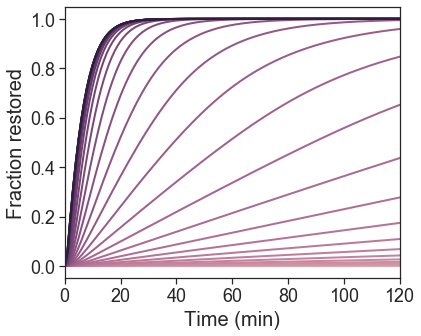

In [64]:
cols = sns.cubehelix_palette(40, reverse = False)

fig, ax = plt.subplots(figsize = (6,5))

for i in range(len(all_data_disagg)):
    ax.plot(time, all_data_disagg[i][:,12]/SUBS_A_0, label = test_param[i], color = cols[i], linewidth = 2)
    
# ax.set_title('[Condensate] = 30; [Hsp70(ATP)] = 30\nk_fold = 1000', fontsize = 20, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 18)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 18)
ax.set_xlabel("Time (min)", fontsize = 20)
ax.set_ylabel("Fraction restored", fontsize = 20)
# ax.legend(loc='upper right', bbox_to_anchor=(1.4,1), fontsize = 16, title = "k_disagg", title_fontsize = 18,
#          labels = test_param)
ax.set_xlim([0,120])
ax.set_ylim([-0.05,1.05])

In [65]:
summary_kdisagg_db = pd.DataFrame(columns = ["kdisagg", "FracRestored"])

for i in range(len(all_data_disagg)):
    Frac_restored = all_data_disagg[i][119,12]/SUBS_A_0
    summary_kdisagg_db.loc[i] = [test_param[i]] + [Frac_restored] 
    

In [66]:
#summary_kdisagg_db.to_csv(r'double_kdisagg_summary.csv')

Text(0, 0.5, 'Fraction restored')

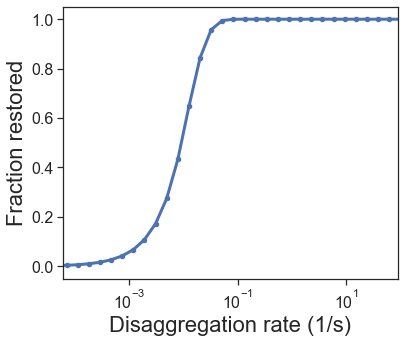

In [66]:
fig, ax = plt.subplots(figsize = (6, 5))

ax = sns.scatterplot(x = "kdisagg", y = "FracRestored" , data = summary_kdisagg_db, s = 40, legend = False)
ax = sns.lineplot(x = "kdisagg", y = "FracRestored", data = summary_kdisagg_db, lw = 3)
# ax.plot(test_param, summary_kdisagg, "ko")
ax.set_xscale('log')
ax.set_ylim([-0.05, 1.05]) 
# ax.set_xlim([1e-6, 1e4])
ax.set_xlim([6e-5, 9e1])
# ax.set_title('[Condensate] = 30; [Hsp70(ATP)] = 30\nk_fold = 1000, k_disagg1 = 1, t = 300 min', fontsize = 16, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 16)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 16)
ax.set_xlabel("Disaggregation rate (1/s)", fontsize = 22)
ax.set_ylabel("Fraction restored", fontsize = 22)
# ax.axvspan(0.05, 0.5, alpha=0.2, color'gray', lw = 0)


**Conclusion:** <br>
Appears consistent with the naive model. Orders of magnitude change in disaggregation can account for almost all-or-nothing difference in dispersal yield (after 2 hr rxn). 

### 2.8 Simulate titration experiment (figure 6)
Use the cooperative model to simulate titration of Hsp104 and Hsp70 and compare the results to the experimental results. Vary kh_s to mimic the effect of Sis1 titration. Vary kDT and kDT_s to mimic the effect of Sse1 titration.

#### 2.8.1 Vary Hsp104 concentration

In [186]:
# Initialize relevant parameters

# concentrations set to the same level used in the experiment 
# 0.2 µM Pab1, 0.5 µM Ssa2, 0.2 µM Sis1 dimer, 0.2 µM Hsp104 hexamer, and +/- 0.1 µM Sse1.
HSP70_ATP_0 = 0.5
HSP104_0 = 0.2
SUBS_A_0 = 0.2

koff_ATP = 2 * 60 
k_disagg = 0.2
k_agg1 = 1
k_fold = 10
kon_ATP2 = 0.1*kon_ATP

kh_s = 1.8 * 60
b = 1 # scaling factor for kDT and kDT_s
kDT = b * kr_adp * ((k_atp * ATP) / (k_atp * ATP + k_adp * ADP))
kDT_s = kDT

In [187]:
# set the range of titration 
test_param = np.logspace(start = -4, stop = 2, num = 30)

# print(test_param)

In [188]:
all_data_titrate_104 = [] 

for i, s in enumerate(test_param):
    HSP104_0 = s
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0, 
                  HSP70_ATP_ADP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_0])
    
    data = odeint(model_double70_v3, zinit, time)
    all_data_titrate_104.append(data)
    

(-0.05, 1.05)

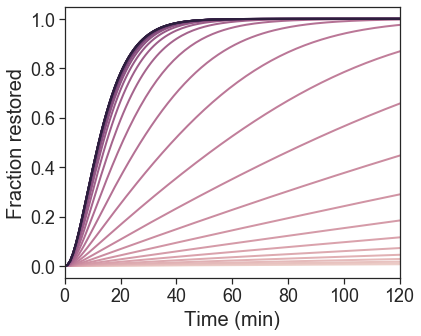

In [189]:
cols = sns.cubehelix_palette(30, reverse = False)

fig, ax = plt.subplots(figsize = (6,5))

for i in range(len(all_data_titrate_104)):
    ax.plot(time, all_data_titrate_104[i][:,12]/SUBS_A_0, label = test_param[i], color = cols[i], linewidth = 2)
    
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 18)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 18)
ax.set_xlabel("Time (min)", fontsize = 20)
ax.set_ylabel("Fraction restored", fontsize = 20)
# ax.legend(loc='upper right', bbox_to_anchor=(1.4,1), fontsize = 16, title = "k_disagg", title_fontsize = 18,
#          labels = test_param)
ax.set_xlim([0,120])
ax.set_ylim([-0.05,1.05])

Quantify maximal rate of dispersal (sliding window analysis) and yield after 120 min for Hsp104 titration.

In [190]:
# Yield quantification

for i in range(len(all_data_titrate_104)):
    print(round(all_data_titrate_104[i][119,12]/SUBS_A_0,2), end = ", ")

# np.shape(all_data)

0.01, 0.01, 0.02, 0.03, 0.04, 0.07, 0.11, 0.18, 0.29, 0.44, 0.65, 0.86, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [191]:
# Maximal rate quantification
# Sliding window analysis to find the maximal rate during the 8 hour reaction (480 min)

all_rates = []    

for j in range(len(all_data_titrate_104)):
    rates = []

    t_window = 2 # sliding time window in min; 
    pts_per_min = 1 # time points within 1 min
    
#     n_slide = int(len(time)/(t_window*pts_per_min))
    n_slide = len(time)-2


    for i in range(n_slide):
        rate = (all_data_titrate_104[j][(i)+t_window, 12] - all_data_titrate_104[j][(i), 12])/t_window
        rates.append(rate)
        
    all_rates.append(rates)
    

In [192]:
# Print maximal rate of dispersal

for i in range(len(all_rates)):
    print(round(max(all_rates[i][:]), 6), end=", ") # show up to 6 digits; unit in µM/min 

1.2e-05, 1.9e-05, 3e-05, 4.8e-05, 7.8e-05, 0.000125, 0.0002, 0.00032, 0.000512, 0.000814, 0.001283, 0.001993, 0.00302, 0.004382, 0.005945, 0.00741, 0.008529, 0.009297, 0.009766, 0.010057, 0.010247, 0.010363, 0.010434, 0.010477, 0.010504, 0.010521, 0.010531, 0.010538, 0.010542, 0.010544, 

In [193]:
summary_titrate_104 = pd.DataFrame(columns = ["Chap_conc", "Relative_conc", "Yield_120min", "MaxRate"])

for i in range(len(all_data_titrate_104)):
    Yield_120min = all_data_titrate_104[i][119,12]/SUBS_A_0
    summary_titrate_104.loc[i] = [test_param[i]] + [test_param[i]/SUBS_A_0] + [Yield_120min] + [max(all_rates[i][:])] 
    

In [194]:
summary_titrate_104.to_csv(r'db_titrate_104.csv')

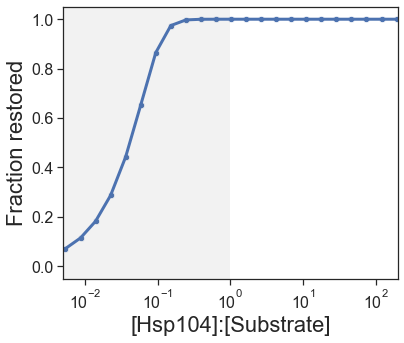

In [195]:
fig, ax = plt.subplots(figsize = (6, 5))

ax = sns.scatterplot(x = "Relative_conc", y = "Yield_120min" , data = summary_titrate_104, s = 40, legend = False)
ax = sns.lineplot(x = "Relative_conc", y = "Yield_120min", data = summary_titrate_104, lw = 3)
# ax.plot(test_param, summary_kdisagg, "ko")
ax.set_xscale('log')
ax.set_ylim([-0.05, 1.05]) 
# ax.set_xlim([1e-6, 1e4])
ax.set_xlim([5e-3, 2e2])
# ax.set_title('[Condensate] = 30; [Hsp70(ATP)] = 30\nk_fold = 1000, k_disagg1 = 1, t = 300 min', fontsize = 16, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 16)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 16)
ax.set_xlabel("[Hsp104]:[Substrate]", fontsize = 22)
ax.set_ylabel("Fraction restored", fontsize = 22)
ax.axvspan(1e-3, 1, alpha=0.1, color = 'gray', lw = 0)


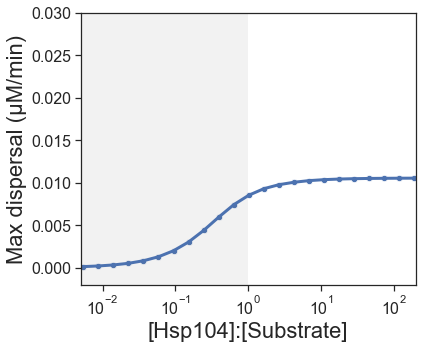

In [196]:
fig, ax = plt.subplots(figsize = (6, 5))

ax = sns.scatterplot(x = "Relative_conc", y = "MaxRate" , data = summary_titrate_104, s = 40, legend = False)
ax = sns.lineplot(x = "Relative_conc", y = "MaxRate", data = summary_titrate_104, lw = 3)
# ax.plot(test_param, summary_kdisagg, "ko")
ax.set_xscale('log')
ax.set_ylim([-0.002, 0.03]) 
ax.set_xlim([5e-3, 2e2])
# ax.set_title('[Condensate] = 30; [Hsp70(ATP)] = 30\nk_fold = 1000, k_disagg1 = 1, t = 300 min', fontsize = 16, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 16)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 16)
ax.set_xlabel("[Hsp104]:[Substrate]", fontsize = 22)
ax.set_ylabel("Max dispersal (µM/min)", fontsize = 22)
ax.axvspan(1e-3, 1, alpha=0.1, color = 'gray', lw = 0)


#### 2.8.2 Vary Hsp70 concentration

In [197]:
# Initialize relevant parameters

# concentrations set to the same level used in the experiment 
# 0.2 µM Pab1, 0.5 µM Ssa2, 0.2 µM Sis1 dimer, 0.2 µM Hsp104 hexamer, and +/- 0.1 µM Sse1.
HSP70_ATP_0 = 0.5
HSP104_0 = 0.2
SUBS_A_0 = 0.2

In [198]:
all_data_titrate_70 = [] 

for i, s in enumerate(test_param):
    HSP70_ATP_0 = s
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0, 
                  HSP70_ATP_ADP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_0])
    
    data = odeint(model_double70_v3, zinit, time)
    all_data_titrate_70.append(data)
    

(-0.05, 1.05)

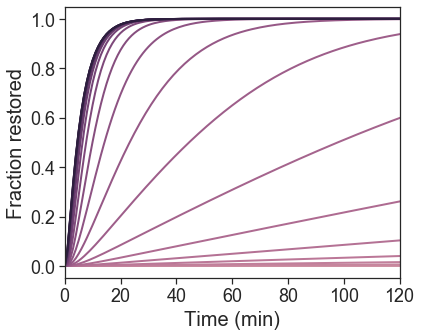

In [199]:
cols = sns.cubehelix_palette(30, reverse = False)

fig, ax = plt.subplots(figsize = (6,5))

for i in range(len(all_data_titrate_70)):
    ax.plot(time, all_data_titrate_70[i][:,12]/SUBS_A_0, label = test_param[i], color = cols[i], linewidth = 2)
    
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 18)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 18)
ax.set_xlabel("Time (min)", fontsize = 20)
ax.set_ylabel("Fraction restored", fontsize = 20)
# ax.legend(loc='upper right', bbox_to_anchor=(1.4,1), fontsize = 16, title = "k_disagg", title_fontsize = 18,
#          labels = test_param)
ax.set_xlim([0,120])
ax.set_ylim([-0.05,1.05])

Quantify maximal rate of dispersal (sliding window analysis) and yield after 120 min for Hsp70 titration.

In [200]:
# Yield quantification

for i in range(len(all_data_titrate_70)):
    print(round(all_data_titrate_70[i][119,12]/SUBS_A_0,2), end = ", ")

# np.shape(all_data)

0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.02, 0.04, 0.1, 0.26, 0.59, 0.94, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [201]:
# Maximal rate quantification
# Sliding window analysis to find the maximal rate during the 8 hour reaction (480 min)

all_rates = []    

for j in range(len(all_data_titrate_70)):
    rates = []

    t_window = 2 # sliding time window in min; 
    pts_per_min = 1 # time points within 1 min
    
#     n_slide = int(len(time)/(t_window*pts_per_min))
    n_slide = len(time)-2

    for i in range(n_slide):
        rate = (all_data_titrate_70[j][(i)+t_window, 12] - all_data_titrate_70[j][(i), 12])/t_window
        rates.append(rate)
        
    all_rates.append(rates)
    

In [202]:
# Print maximal rate of dispersal

for i in range(len(all_rates)):
    print(round(max(all_rates[i][:]), 6), end=", ") # show up to 6 digits; unit in µM/min 

0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-06, 2e-06, 4e-06, 1e-05, 2.7e-05, 7e-05, 0.000181, 0.000461, 0.00114, 0.002625, 0.005287, 0.00898, 0.013024, 0.016892, 0.020077, 0.022433, 0.023991, 0.024591, 0.025486, 0.025923, 0.026128, 0.026211, 0.026218, 

In [203]:
summary_titrate_70 = pd.DataFrame(columns = ["Chap_conc", "Relative_conc", "Yield_120min", "MaxRate"])

for i in range(len(all_data_titrate_70)):
    Yield_120min = all_data_titrate_70[i][119,12]/SUBS_A_0
    summary_titrate_70.loc[i] = [test_param[i]] + [test_param[i]/SUBS_A_0] + [Yield_120min] + [max(all_rates[i][:])] 
    

In [204]:
summary_titrate_70.to_csv(r'db_titrate_70.csv')

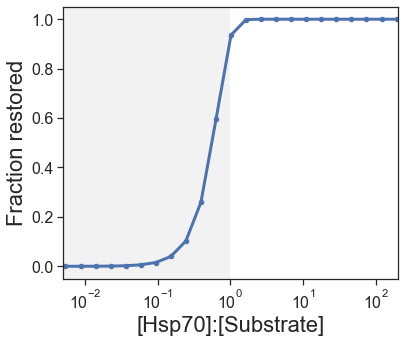

In [205]:
fig, ax = plt.subplots(figsize = (6, 5))

ax = sns.scatterplot(x = "Relative_conc", y = "Yield_120min" , data = summary_titrate_70, s = 40, legend = False)
ax = sns.lineplot(x = "Relative_conc", y = "Yield_120min", data = summary_titrate_70, lw = 3)
# ax.plot(test_param, summary_kdisagg, "ko")
ax.set_xscale('log')
ax.set_ylim([-0.05, 1.05]) 
# ax.set_xlim([1e-6, 1e4])
ax.set_xlim([5e-3, 2e2])
# ax.set_title('[Condensate] = 30; [Hsp70(ATP)] = 30\nk_fold = 1000, k_disagg1 = 1, t = 300 min', fontsize = 16, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 16)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 16)
ax.set_xlabel("[Hsp70]:[Substrate]", fontsize = 22)
ax.set_ylabel("Fraction restored", fontsize = 22)
ax.axvspan(1e-3, 1, alpha=0.1, color = 'gray', lw = 0)


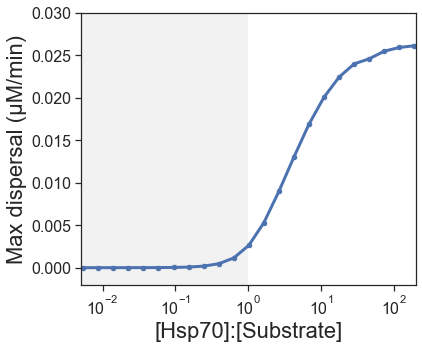

In [206]:
fig, ax = plt.subplots(figsize = (6, 5))

ax = sns.scatterplot(x = "Relative_conc", y = "MaxRate" , data = summary_titrate_70, s = 40, legend = False)
ax = sns.lineplot(x = "Relative_conc", y = "MaxRate", data = summary_titrate_70, lw = 3)
# ax.plot(test_param, summary_kdisagg, "ko")
ax.set_xscale('log')
ax.set_ylim([-0.002, 0.03]) 
ax.set_xlim([5e-3, 2e2])
# ax.set_title('[Condensate] = 30; [Hsp70(ATP)] = 30\nk_fold = 1000, k_disagg1 = 1, t = 300 min', fontsize = 16, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 16)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 16)
ax.set_xlabel("[Hsp70]:[Substrate]", fontsize = 22)
ax.set_ylabel("Max dispersal (µM/min)", fontsize = 22)
ax.axvspan(1e-3, 1, alpha=0.1, color = 'gray', lw = 0)


#### 2.8.3 Vary kh_s to simulate Sis1 titration

In [207]:
# Initialize relevant parameters

HSP70_ATP_0 = 0.5
HSP104_0 = 0.2
SUBS_A_0 = 0.2


In [208]:
# set the range of titration 
test_param = np.logspace(start = -1, stop = 4, num = 30)

print(test_param)

[1.00000000e-01 1.48735211e-01 2.21221629e-01 3.29034456e-01
 4.89390092e-01 7.27895384e-01 1.08263673e+00 1.61026203e+00
 2.39502662e+00 3.56224789e+00 5.29831691e+00 7.88046282e+00
 1.17210230e+01 1.74332882e+01 2.59294380e+01 3.85662042e+01
 5.73615251e+01 8.53167852e+01 1.26896100e+02 1.88739182e+02
 2.80721620e+02 4.17531894e+02 6.21016942e+02 9.23670857e+02
 1.37382380e+03 2.04335972e+03 3.03919538e+03 4.52035366e+03
 6.72335754e+03 1.00000000e+04]


In [209]:
all_data_titrate_kh_s = [] 

for i, s in enumerate(test_param):
    kh_s = s
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0, 
                  HSP70_ATP_ADP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_0])
    
    data = odeint(model_double70_v3, zinit, time)
    all_data_titrate_kh_s.append(data)
    

(-0.05, 1.05)

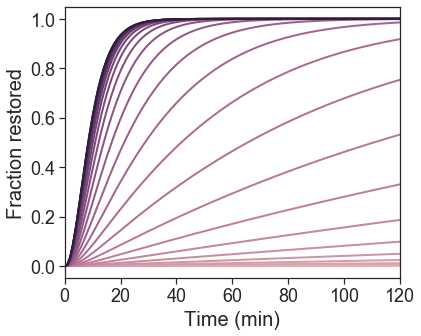

In [210]:
cols = sns.cubehelix_palette(30, reverse = False)

fig, ax = plt.subplots(figsize = (6,5))

for i in range(len(all_data_titrate_kh_s)):
    ax.plot(time, all_data_titrate_kh_s[i][:,12]/SUBS_A_0, label = test_param[i], color = cols[i], linewidth = 2)
    
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 18)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 18)
ax.set_xlabel("Time (min)", fontsize = 20)
ax.set_ylabel("Fraction restored", fontsize = 20)
# ax.legend(loc='upper right', bbox_to_anchor=(1.4,1), fontsize = 16, title = "k_disagg", title_fontsize = 18,
#          labels = test_param)
ax.set_xlim([0,120])
ax.set_ylim([-0.05,1.05])

Quantify rate and yield for kh_s titration.

In [211]:
# Yield quantification

for i in range(len(all_data_titrate_kh_s)):
    print(round(all_data_titrate_kh_s[i][119,12]/SUBS_A_0,2), end = ", ")

# np.shape(all_data)

0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.05, 0.1, 0.18, 0.33, 0.53, 0.75, 0.92, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [212]:
# Maximal rate quantification
# Sliding window analysis to find the maximal rate during the 8 hour reaction (480 min)

all_rates = []    

for j in range(len(all_data_titrate_kh_s)):
    rates = []

    t_window = 2 # sliding time window in min; 
    pts_per_min = 1 # time points within 1 min
    
#     n_slide = int(len(time)/(t_window*pts_per_min))
    n_slide = len(time)-2


    for i in range(n_slide):
        rate = (all_data_titrate_kh_s[j][(i)+t_window, 12] - all_data_titrate_kh_s[j][(i), 12])/t_window
        rates.append(rate)
        
    all_rates.append(rates)
    

In [213]:
# Print maximal rate of dispersal

for i in range(len(all_rates)):
    print(round(max(all_rates[i][:]), 6), end=", ") # show up to 6 digits; unit in µM/min 

0.0, 0.0, 1e-06, 2e-06, 4e-06, 9e-06, 2e-05, 4.2e-05, 8.7e-05, 0.000176, 0.000343, 0.000639, 0.001128, 0.001874, 0.002918, 0.004255, 0.005815, 0.007498, 0.009161, 0.010688, 0.011987, 0.013093, 0.013926, 0.014518, 0.015004, 0.015352, 0.015593, 0.015757, 0.015869, 0.015945, 

In [214]:
summary_titrate_kh_s = pd.DataFrame(columns = ["kh_s", "Yield_120min", "MaxRate"])

for i in range(len(all_data_titrate_kh_s)):
    Yield_120min = all_data_titrate_kh_s[i][119,12]/SUBS_A_0
    summary_titrate_kh_s.loc[i] = [test_param[i]] + [Yield_120min] + [max(all_rates[i][:])] 
    

In [215]:
summary_titrate_kh_s.to_csv(r'db_titrate_khs.csv')

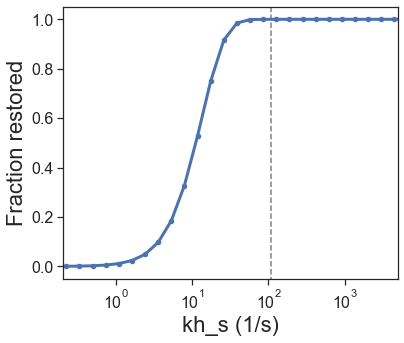

In [108]:
fig, ax = plt.subplots(figsize = (6, 5))

ax = sns.scatterplot(x = "kh_s", y = "Yield_120min" , data = summary_titrate_kh_s, s = 40, legend = False)
ax = sns.lineplot(x = "kh_s", y = "Yield_120min", data = summary_titrate_kh_s, lw = 3)
# ax.plot(test_param, summary_kdisagg, "ko")
ax.set_xscale('log')
ax.set_ylim([-0.05, 1.05]) 
# ax.set_xlim([1e-6, 1e4])
ax.set_xlim([2e-1, 5e3])
# ax.set_title('[Condensate] = 30; [Hsp70(ATP)] = 30\nk_fold = 1000, k_disagg1 = 1, t = 300 min', fontsize = 16, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 16)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 16)
ax.set_xlabel("kh_s (1/s)", fontsize = 22)
ax.set_ylabel("Fraction restored", fontsize = 22)
# ax.axvspan(1e-3, 1, alpha=0.1, color = 'gray', lw = 0)
ax.vlines(x = 1.8 * 60, ymin = -1, ymax = 2, ls='--', color = "gray") #1.8 * 60 = default kh_s


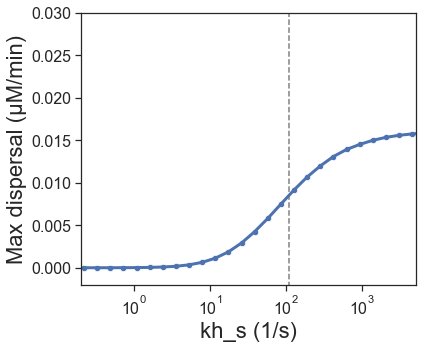

In [109]:
fig, ax = plt.subplots(figsize = (6, 5))

ax = sns.scatterplot(x = "kh_s", y = "MaxRate" , data = summary_titrate_kh_s, s = 40, legend = False)
ax = sns.lineplot(x = "kh_s", y = "MaxRate", data = summary_titrate_kh_s, lw = 3)
# ax.plot(test_param, summary_kdisagg, "ko")
ax.set_xscale('log')
ax.set_ylim([-0.002, 0.03]) 
ax.set_xlim([2e-1, 5e3])
# ax.set_title('[Condensate] = 30; [Hsp70(ATP)] = 30\nk_fold = 1000, k_disagg1 = 1, t = 300 min', fontsize = 16, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 16)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 16)
ax.set_xlabel("kh_s (1/s)", fontsize = 22)
ax.set_ylabel("Max dispersal (µM/min)", fontsize = 22)
# ax.axvspan(1e-3, 1, alpha=0.1, color = 'gray', lw = 0)
ax.vlines(x = 1.8 * 60, ymin = -1, ymax = 2, ls='--', color = "gray") #1.8 * 60 = default kh_s


#### 2.8.4 Vary kDT and kDT_s to simulate Sse1 titration

In [123]:
# Initialize relevant parameters

# concentrations set to the same level used in the experiment 
# 0.2 µM Pab1, 0.5 µM Ssa2, 0.2 µM Sis1 dimer, 0.2 µM Hsp104 hexamer, and +/- 0.1 µM Sse1.
HSP70_ATP_0 = 0.5
HSP104_0 = 0.2
SUBS_A_0 = 0.2

koff_ATP = 2 * 60 
k_disagg = 0.2
k_agg1 = 1
k_fold = 10

kh_s = 1.8 * 60
b = 1 # scaling factor for kDT and kDT_s
kDT = b * kr_adp * ((k_atp * ATP) / (k_atp * ATP + k_adp * ADP))
kDT_s = kDT



In [174]:
# set the range of titration 
# test_param = np.logspace(start = -3, stop = 3, num = 30)
test_param = [0.148, 0.444, 1.333, 4, 12]
test_param.reverse()
# test_param = [0]

print(test_param)

[12, 4, 1.333, 0.444, 0.148]


In [175]:
all_data_titrate_kDT = [] 

for i, s in enumerate(test_param):
#     b = s
#     kDT = b * kr_adp * ((k_atp * ATP) / (k_atp * ATP + k_adp * ADP))
    kDT = s
    kDT_s = kDT
    zinit = np.array([HSP70_ATP_0, 
                  HSP70_ADP_0, 
                  HSP104_0, 
                  SUBS_A_0, 
                  HSP70_ATP_SUBS_A_0, 
                  HSP70_ADP_SUBS_A_0, 
                  HSP70_ADP_SUBS_AP_0, 
                  HSP70_ATP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_104_0, 
                  HSP104_SUBS_AP_0,  
                  SUBS_U_0,
                  SUBS_M_0, 
                  SUBS_F_0, 
                  HSP70_ATP_SUBS_M_0, 
                  HSP70_ADP_SUBS_M_0, 
                  HSP70_ADP_SUBS_U_0, 
                  HSP70_ATP_SUBS_U_0, 
                  HSP70_ATP_ADP_SUBS_AP_0, 
                  HSP70_ADP_ADP_SUBS_AP_0])
    
    data = odeint(model_double70_v3, zinit, time)
    all_data_titrate_kDT.append(data)
    

(-0.05, 1.05)

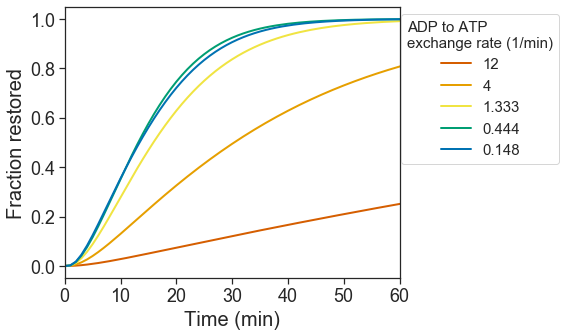

In [176]:
# cols = sns.cubehelix_palette(5, reverse = False)
cols = ["#D55E00", "#E69F00", "#F0E442", "#009E73",  "#0072B2"]#, "#999999"] # matching R colors
# cols.reverse()

fig, ax = plt.subplots(figsize = (6,5))

for i in range(len(all_data_titrate_kDT)):
    ax.plot(time, all_data_titrate_kDT[i][:,12]/SUBS_A_0, label = test_param[i], color = cols[i], linewidth = 2)
    
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 18)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 18)
ax.set_xlabel("Time (min)", fontsize = 20)
ax.set_ylabel("Fraction restored", fontsize = 20)
ax.legend(loc='upper right', bbox_to_anchor=(1.5,1), fontsize = 15, title = "ADP to ATP\nexchange rate (1/min)", title_fontsize = 15,
         labels = test_param)
ax.set_xlim([0, 60])
ax.set_ylim([-0.05,1.05])

In [161]:
# Export csv
columns = [f'kDT_{num}' for num in test_param]

d = {'kDT_1' : all_data_titrate_kDT[0][:,12]/SUBS_A_0,
     'kDT_2' : all_data_titrate_kDT[1][:,12]/SUBS_A_0, 
     'kDT_3' : all_data_titrate_kDT[2][:,12]/SUBS_A_0, 
     'kDT_4' : all_data_titrate_kDT[3][:,12]/SUBS_A_0, 
     'kDT_5' : all_data_titrate_kDT[4][:,12]/SUBS_A_0}

df_kDT = pd.DataFrame(data = d)
df_kDT.to_csv(r'py_titrate_Sse1.csv')
# np.shape(all_data_titrate_kDT[][:,12])


In [162]:
# Yield quantification

for i in range(len(all_data_titrate_kDT)):
    print(round(all_data_titrate_kDT[i][119,12]/SUBS_A_0,2), end = ", ")

# np.shape(all_data)

0.69, 0.71, 0.76, 0.83, 0.92, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 0.92, 0.68, 0.38, 0.16, 0.06, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [163]:
# Maximal rate quantification
# Sliding window analysis to find the maximal rate during the 8 hour reaction (480 min)

all_rates = []    

for j in range(len(all_data_titrate_kDT)):
    rates = []

    t_window = 2 # sliding time window in min; 
    pts_per_min = 1 # time points within 1 min
    
#     n_slide = int(len(time)/(t_window*pts_per_min))
    n_slide = len(time)-2


    for i in range(n_slide):
        rate = (all_data_titrate_kDT[j][(i)+t_window, 12] - all_data_titrate_kDT[j][(i), 12])/t_window
        rates.append(rate)
        
    all_rates.append(rates)
    

In [164]:
# Print maximal rate of dispersal

for i in range(len(all_rates)):
    print(round(max(all_rates[i][:]), 6), end=", ") # show up to 6 digits; unit in µM/min 

0.008551, 0.008555, 0.008561, 0.008571, 0.008587, 0.008612, 0.008651, 0.008709, 0.008793, 0.008941, 0.009174, 0.009474, 0.009711, 0.009697, 0.009182, 0.008097, 0.006539, 0.004738, 0.003001, 0.001627, 0.000747, 0.000293, 0.0001, 3.1e-05, 9e-06, 2e-06, 1e-06, 0.0, 0.0, 0.0, 

In [165]:
summary_titrate_kDT = pd.DataFrame(columns = ["kDT", "Yield_120min", "MaxRate"])

for i in range(len(all_data_titrate_kDT)):
    Yield_120min = all_data_titrate_kDT[i][119,12]/SUBS_A_0
    summary_titrate_kDT.loc[i] = [test_param[i]] + [Yield_120min] + [max(all_rates[i][:])] 
    

In [169]:
#summary_titrate_kDT.to_csv(r'db_titrate_kDT.csv')

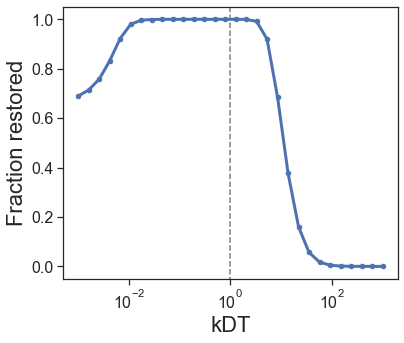

In [167]:
fig, ax = plt.subplots(figsize = (6, 5))

ax = sns.scatterplot(x = "kDT", y = "Yield_120min" , data = summary_titrate_kDT, s = 40, legend = False)
ax = sns.lineplot(x = "kDT", y = "Yield_120min", data = summary_titrate_kDT, lw = 3)
# ax.plot(test_param, summary_kdisagg, "ko")
ax.set_xscale('log')
ax.set_ylim([-0.05, 1.05]) 
# ax.set_xlim([1e-6, 1e4])
# ax.set_xlim([5e-3, 2e2])
# ax.set_title('[Condensate] = 30; [Hsp70(ATP)] = 30\nk_fold = 1000, k_disagg1 = 1, t = 300 min', fontsize = 16, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 16)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 16)
ax.set_xlabel("kDT", fontsize = 22)
ax.set_ylabel("Fraction restored", fontsize = 22)
# ax.axvspan(1e-3, 1, alpha=0.1, color = 'gray', lw = 0)
ax.vlines(x = 1, ymin = -1, ymax = 2, ls='--', color = "gray")



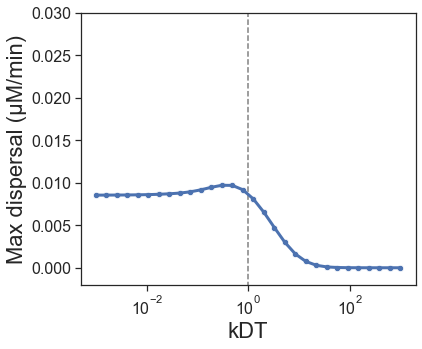

In [168]:
fig, ax = plt.subplots(figsize = (6, 5))

ax = sns.scatterplot(x = "kDT", y = "MaxRate" , data = summary_titrate_kDT, s = 40, legend = False)
ax = sns.lineplot(x = "kDT", y = "MaxRate", data = summary_titrate_kDT, lw = 3)
# ax.plot(test_param, summary_kdisagg, "ko")
ax.set_xscale('log')
ax.set_ylim([-0.002, 0.03]) 
# ax.set_xlim([5e-3, 2e2])
# ax.set_title('[Condensate] = 30; [Hsp70(ATP)] = 30\nk_fold = 1000, k_disagg1 = 1, t = 300 min', fontsize = 16, loc = "left")
ax.xaxis.set_tick_params(bottom = "off", direction = "out", labelsize = 16)
ax.yaxis.set_tick_params(left = "off", direction = "out", labelsize = 16)
ax.set_xlabel("kDT", fontsize = 22)
ax.set_ylabel("Max dispersal (µM/min)", fontsize = 22)
# ax.axvspan(1e-3, 1, alpha=0.1, color = 'gray', lw = 0)
ax.vlines(x = 1, ymin = -1, ymax = 1, ls='--', color = "gray")


Varying kDT and kDT_s captures the inhibitory effect in the presence of excess Sse1. However, the simulation does not capture the beneficial effect of substoichiometric Sse1 on both yield and rate. This could be because the model does not fully capture Sse1's effect on the disaggregation system. E.g. Sse1 may help recycling Hsp70(ADP) and precent it from unproductively associating with substrates in experiment. In this simulation, however, we assume that Hsp70(ADP) does not bind substrate and thus the beneficial effect of Sse1 on keeping substrate-bound Hsp70(ADP) low would not be apparent in the model. 